
# [TMDB 5000 MOVIES Revenue Prediction Project]


## Introduction

<font color="hotpink">
We are living in a time where movies are seemingly more popular and attractive than written sources such as books, which makes movies much more profitable than any other media source. This project includes the collection of TMDB 5000 Movies and their relationships. My aim is to determine different conclusions on frequencies and features of movies. We have a dataset that is collected from a long span of dates but there are a few movies entered into data compared to recent data. So we may need to clear this accordingly in order to deduce the spread (resulted in more skewed data). Afterward, the dataset needs to be examined and mined by the group members regarding its budget, ratings, popularity, genres, title, cast, and crew(by the features of the dataset). Lastly, the project will be finished with a discussion of the descriptive results and possible future works about the ML model.
</font>

### Problem Definition

<font color="royalblue">
In order to achieve the goal of this project, our main goal is to predict the revenues according to the other features of the dataset (country, language, budget, popularity, votes, etc.). In our data, the goal is planning to use some of the statistical methods like z-score testing, hypothesis testing and pearson correlation tests to figure out and choose the features and eliminate the unrelated ones, signifying different relationships and finding out relevance and dependence between the features and samples. In order to achieve the goal of this project, members will use feature engineering and statistical methods to detect these kinds of relationships. After cleaning, and selecting the right type and amount of features, we will start designing our model. While designing our model, we will re-check the previously calculated selections and do further changes depending on the results of our model. In the end, our purpose is to create the best model, that has low bias and low variance between the data, and has the least error score. Also we will try our model to be applicable to new data.
</font>

What about binarizing the presence of Website ? 

### Utilized Datasets

<font color="hotpink">
Kaggle Dataset: ​https://www.kaggle.com/tmdb/tmdb-movie-metadata 

IMDb Dataset: https://www.kaggle.com/ashirwadsangwan/imdb-dataset?select=title.ratings.tsv.gz
</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import special
from os.path import join
import seaborn as sns

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount("./drive", force_remount=True)

path_prefix = "./drive/My Drive"

Mounted at ./drive


In [3]:
import json
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])

In [4]:
keywords_path = "movie_metadata_with_keyword_features.csv"
df_kw = pd.read_csv(join(path_prefix, keywords_path))

df_kw = df_kw[["movie_title","plot_keywords","language", "country", "director_facebook_likes", "actor_3_facebook_likes", "num_voted_users", 
                "content_rating","actor_1_facebook_likes", "actor_2_facebook_likes", "actor_3_facebook_likes",
                 "cast_total_facebook_likes","movie_facebook_likes","imdb_score", "aspect_ratio", "budget"]]
df_kw.rename(columns={"budget":"budget_2"},inplace= True)
df_kw.head(2)
df_kw.rename(columns= {"movie_title": "title"}, inplace = True)

In [5]:
path = "tmdb_5000_movies.csv"
path_2 = "tmdb_5000_credits.csv"
df= load_tmdb_movies(join(path_prefix, path))
df_credits = load_tmdb_credits(join(path_prefix, path_2))

In [6]:

df_stacked =pd.concat([df, df_kw, df_credits], keys=["title","title","title"],axis= 1,
                      join = "inner")

df_stacked = df_stacked.droplevel(0, axis=1)



In [7]:
print(df_stacked.shape)

(4803, 40)


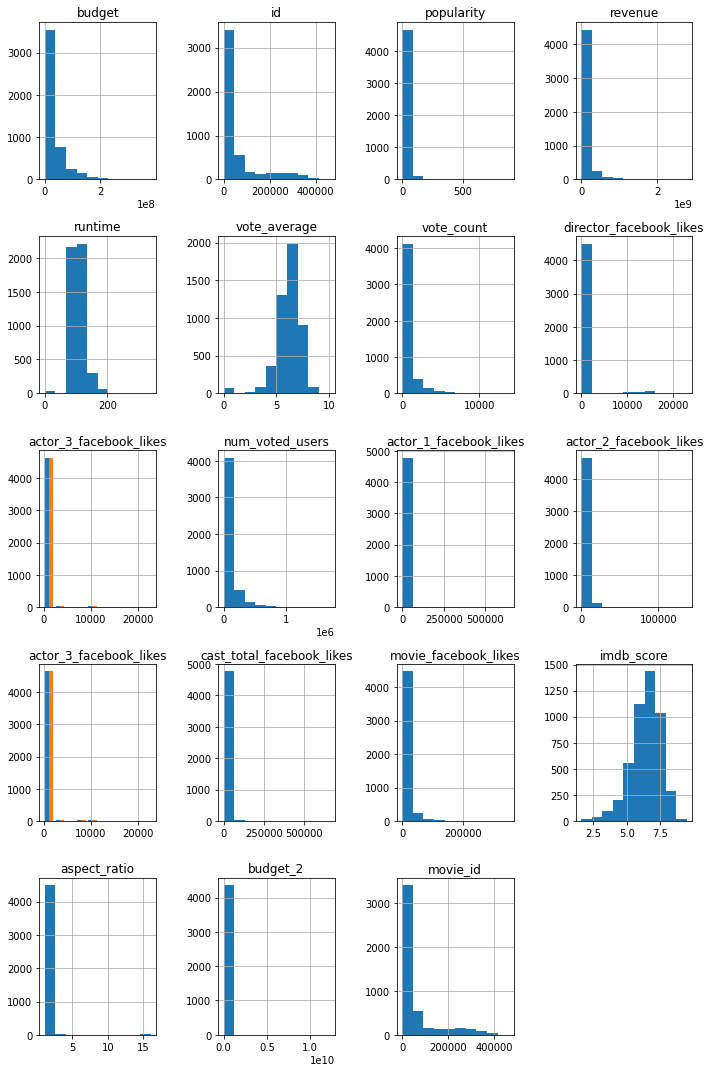

In [8]:

ax =df_stacked.hist(figsize= (10,15))
plt.title("Initial Visualization of Numerical Data")
plt.tight_layout()

In [9]:
df_kw = df_kw.loc[df_kw.imdb_score >= 8]
for movie in df_kw.title:
  n = np.random.randint(0, len(df_kw))
  print(df_kw.iloc[n])
  break

title                                     Howl's Moving Castle 
plot_keywords                anime|castle|demon|steampunk|witch
language                                               Japanese
country                                                   Japan
director_facebook_likes                                    6000
actor_3_facebook_likes                                      422
num_voted_users                                          214091
content_rating                                               PG
actor_1_facebook_likes                                    23000
actor_2_facebook_likes                                      713
actor_3_facebook_likes                                      422
cast_total_facebook_likes                                 24263
movie_facebook_likes                                      13000
imdb_score                                                  8.2
aspect_ratio                                               1.85
budget_2                                

## Data Exploration and Dataset Concatenation


#### Checking the similarities by the budget values which is similar.

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Budget values of two separated datasets:')

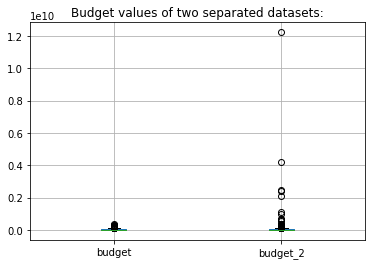

In [10]:
df_stacked.boxplot(column = ["budget", "budget_2"])
plt.title("Budget values of two separated datasets:")

From this dataset, we see some budget_2 data that are above the 400 Million  that are not in budget data, So we subtract them and check the spread of two data.

In [11]:
print("No. of budget values that are bigger than 400Million for budget_1"
,df_stacked.loc[df_stacked.budget > 0.4*(10**9)]["budget"].count())

print("No. of budget values that are bigger than 400Million for budget_2"
,df_stacked.loc[df_stacked.budget_2 > 0.4*(10**9)]["budget"].count())

No. of budget values that are bigger than 400Million for budget_1 0
No. of budget values that are bigger than 400Million for budget_2 11


In [12]:
df_stacked = df_stacked.loc[df_stacked.budget_2 < 0.4*(10**9)]

Text(0.5, 1.0, 'budget values that are taken from similar but different datasets')

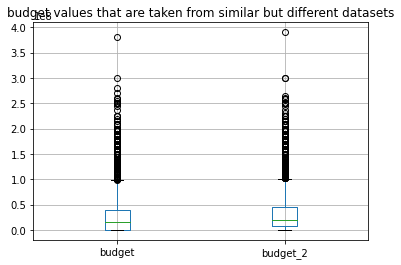

In [13]:
df_stacked.boxplot(column = ["budget", "budget_2"])
plt.title("budget values that are taken from similar but different datasets", fontdict = {"fontsize":"large"})

#### Applying a sample t test for checking the similarity of the budget distributions.

    H0: Confidence level coming from t-stat of two samples is above 90%
    H1: Confidence level is below 90% 

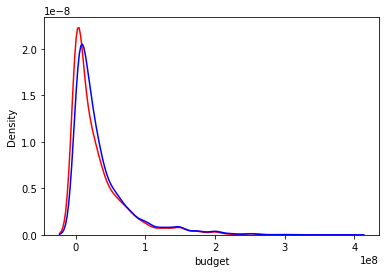

In [14]:
sns.kdeplot(df_stacked.budget, color = "red")
sns.kdeplot(df_stacked.budget_2, color = "blue")

In [15]:
import scipy.stats as stats
sample1 = df_stacked.budget
sample2 = df_stacked.budget_2
t_stat, p_val = stats.ttest_ind(sample1, sample2, equal_var=False)
print("Degrees of freedom: 2")
print(f"Our abs value of t stat: {round(abs(t_stat),4) }")

print("Our confidence level is apprx. 95.6%")
print("We accept the null hypothesis")

Degrees of freedom: 2
Our abs value of t stat: 4.956
Our confidence level is apprx. 95.6%
We accept the null hypothesis


From the t score, we check the t table and see that we have more than 95% confidence between two samples of budget values. So we will keep the concatenated data.

In [16]:
del df_stacked["budget_2"]

## Intro to Data Analysis

#### Initial feature elimination -Getting rid of the unnecessary features-

In [17]:
df_stacked.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'title', 'plot_keywords', 'language', 'country',
       'director_facebook_likes', 'actor_3_facebook_likes', 'num_voted_users',
       'content_rating', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
       'actor_3_facebook_likes', 'cast_total_facebook_likes',
       'movie_facebook_likes', 'imdb_score', 'aspect_ratio', 'movie_id',
       'title', 'cast', 'crew'],
      dtype='object')

In [18]:
del df["homepage"], df["original_title"], df["tagline"], df["status"],df["overview"]

In [19]:
"""df_stacked.plot_keywords.apply(lambda x: str(x).split("|"))
"""

'df_stacked.plot_keywords.apply(lambda x: str(x).split("|"))\n'

In [20]:
"""plot_kws = {}
df_stacked.dropna(subset = ["plot_keywords"], inplace= True)
for i in df_stacked.plot_keywords:
    list_k = i.split("|")
    for item in list_k:
      if item not in plot_kws.keys():
        plot_kws[item] = 1
      else:
        plot_kws[item] += 1"""

'plot_kws = {}\ndf_stacked.dropna(subset = ["plot_keywords"], inplace= True)\nfor i in df_stacked.plot_keywords:\n    list_k = i.split("|")\n    for item in list_k:\n      if item not in plot_kws.keys():\n        plot_kws[item] = 1\n      else:\n        plot_kws[item] += 1'

In [21]:
"""kws = pd.DataFrame(plot_kws, index = ["count"]).T

len(kws.sort_values(by = "count",ascending= False))"""

'kws = pd.DataFrame(plot_kws, index = ["count"]).T\n\nlen(kws.sort_values(by = "count",ascending= False))'

In [22]:

df_num = df_stacked[["title", "release_date", "runtime", "popularity","vote_average", "vote_count", "budget", "revenue",
                     'director_facebook_likes', 'num_voted_users','actor_3_facebook_likes',
                     'actor_1_facebook_likes', 'actor_2_facebook_likes',
                     'cast_total_facebook_likes',
                     'movie_facebook_likes', 'imdb_score', 'aspect_ratio', "genres", "production_companies", "keywords",
                     "language", "country",'content_rating', 'crew','cast']]

import datetime as datetime
pd.to_datetime(df_stacked["release_date"])
df_num['year'] = pd.DatetimeIndex(df_stacked['release_date']).year
df_num["age"] = pd.datetime.now().year - df_num["year"]
df_num.drop(columns = ["release_date", "year"], inplace= True)
df_num = df_num.loc[:,~df_num.columns.duplicated()]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.

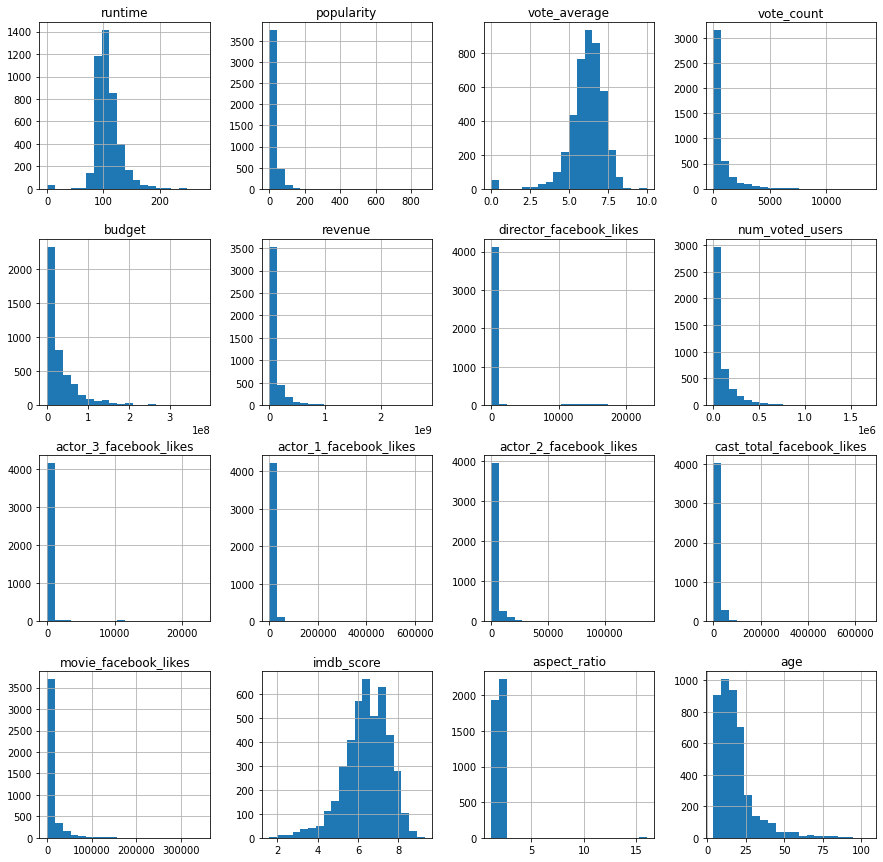

In [23]:
df_num.hist(figsize=(15, 15), bins = 20)
plt.show()

Let's check our revenue and budget values whether they have any NaN values:

In [24]:
print(f"The No. of NaN values for Revenue:  {df_num.loc[df_num.revenue == 0].revenue.count()}")
print(f"The No. of NaN values for Revenue:  {df_num.loc[df_num.budget == 0].budget.count()}")

The No. of NaN values for Revenue:  1255
The No. of NaN values for Revenue:  904


Wooah, there are more empty values than I thought, so we might think to fill them with the mean or median. If the data is skewed, we will fill it with the *MEDIAN* of the dataset.

Text(0.5, 0.98, 'Distribution Graphs for Revenue and Budget')

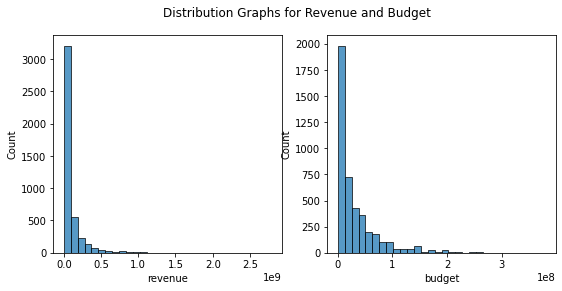

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize =(9,4))
ax1 = sns.histplot(df_num.revenue, bins = 30, ax= ax1)
ax2 = sns.histplot(df_num.budget,bins = 30, ax = ax2)
plt.suptitle("Distribution Graphs for Revenue and Budget")

We fill all the empty revenue and budget values with the median of the data as both data are highly right skewed.

In [26]:
revenue_median = df_num['revenue'].median()
budget_median = df_num['budget'].median()

df_num['revenue'].replace(0, revenue_median, inplace = True)
df_num['budget'].replace(0, budget_median, inplace = True)

In [27]:
print(f"The No. of NaN values for Revenue:  {df_num.loc[df_num.revenue == 0].revenue.count()}")
print(f"The No. of NaN values for Budget:  {df_num.loc[df_num.budget == 0].budget.count()}")

The No. of NaN values for Revenue:  0
The No. of NaN values for Budget:  0


We also delete the movies whose revenues and budgets are less than 1K. I am depending this number to the ınformation I gained by wikipedias low budget films:

 In 1998, Christopher Nolan's first film Following was filmed on a budget of £3,000. Nolan then received another £3,000 to "blow it up to 35mm". Also we have double checked the movie prices that contributes to this dataset, and we decided that minimum price that could be investigated should be 1000.

In [28]:
print("Movies whose gross are less than 1000: ",df_num.loc[df_num.revenue < 1000]["revenue"].count())
print("Movies that are cheaper than 1000: ", df_num.loc[df_num.budget < 1000]["budget"].count())

Movies whose gross are less than 1000:  19
Movies that are cheaper than 1000:  29


In [29]:
df_num = df_num.loc[(df_num.revenue >= 1000) & (df_num.budget >= 1000)]

In [30]:
df_num.isnull().sum()

title                          0
runtime                        1
popularity                     0
vote_average                   0
vote_count                     0
budget                         0
revenue                        0
director_facebook_likes        8
num_voted_users                0
actor_3_facebook_likes         8
actor_1_facebook_likes         2
actor_2_facebook_likes         4
cast_total_facebook_likes      0
movie_facebook_likes           0
imdb_score                     0
aspect_ratio                 182
genres                         0
production_companies           0
keywords                       0
language                       6
country                        1
content_rating               151
crew                           0
cast                           0
age                            1
dtype: int64

Taking out the null values of the remaining features:



*   facebook_likes of actors: drop all NaN's
*   aspect_ratio: We'll will fill them with relevant data
*   Content_rating: We'll fill them with most frequent number
*   age and runtime: There is only one for each, so drop them



In [31]:
#dropping some nans
df_num.dropna(axis =0 , how = 'any',subset = ["age", "runtime", "actor_1_facebook_likes",  "actor_2_facebook_likes", "actor_3_facebook_likes", "director_facebook_likes"], inplace = True)

In [32]:
for i in ["age", "runtime", "actor_1_facebook_likes",  "actor_2_facebook_likes", "actor_3_facebook_likes"]:
  print(df_num[i].isnull().sum())

0
0
0
0
0


Now we will do some calculations on aspect_ratio, we will check its distribution. If it is skewed, we will fill the empty values with the median else with mean.

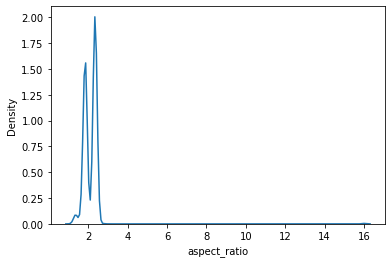

In [33]:
sns.kdeplot(df_num.aspect_ratio)

In [34]:
aspect_ratio_median = df_num["aspect_ratio"].median()
df_num["aspect_ratio"] = df_num['aspect_ratio'].fillna( aspect_ratio_median)

print(df_num.aspect_ratio.isnull().sum())

0


In [35]:
ratings_list = df_num.content_rating.value_counts().index
ratings_list

Index(['R', 'PG-13', 'PG', 'G', 'Not Rated', 'Approved', 'Unrated', 'X',
       'Passed', 'NC-17', 'GP', 'TV-G', 'M', 'TV-PG', 'TV-14'],
      dtype='object')

Our most frequent rating is "R" rating means Restricted, which may not be right for some of the NaN values, the 'Approved' is a more general term, and in order to reduce overfitting, We will fill the content rating NaNs with "Approved":

In [36]:
df_num["content_rating"].fillna("Approved", inplace = True)
df_num.content_rating.isnull().sum()

0

We have handled all the null values but we didn't subtract some of the similar and redundant features with some possible data leakage problems. Let's keep our foolest dataset for starting.

In [37]:
df_foolest = df_num

## Feature Analysis and Dimensionality Reduction (if necessary) of the Numerical Features

### Let's make a Feature Analysis and Detect our features that are dependent or redundant for our model.

Next, we compare the correlation between features and remove if one of two features that have a correlation higher than 0.9. By doing this:


*   We are checking whether there are more than one features that are dependent to each other and that effects our expected value in a very similar manner.




In [38]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numeric= df_num.select_dtypes(include=numerics)
corr = df_numeric.corr()

#### Analysis of Redundant Features on the dataset

In [39]:

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.80:
            if columns[j]:
                columns[j] = False
                

selected_columns = df_numeric.columns
#those are the columns that has passed the test.

df_numeric = df_numeric[selected_columns]
# take the list of columns that has passed the test

df_numeric.head()

runtime  popularity  vote_average  ...  imdb_score  aspect_ratio   age
0    162.0  150.437577           7.2  ...         7.9          1.78  12.0
1    169.0  139.082615           6.9  ...         7.1          2.35  14.0
2    148.0  107.376788           6.3  ...         6.8          2.35   6.0
3    165.0  112.312950           7.6  ...         8.5          2.35   9.0
5    139.0  115.699814           5.9  ...         6.6          2.35  14.0

[5 rows x 16 columns]

In [40]:
for i in  df_num.columns:
  if np.issubdtype(df_num[i].dtype, np.number):
    if i not in selected_columns:
      print(f"{i} should be deleted from df_nums")

It seems like we do not have any redundant features that are inter-dependent with another predictor variable, then we shall continue.

In [41]:
selected_columns_1 = selected_columns.drop("revenue")

In [42]:
df_numeric = df_numeric.fillna(method='ffill')

### Initial Feature Selection with Backward Elimination

Pearson's r formula for Correlation:

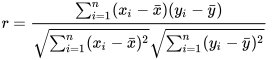

It seems there are no significantly dependent variables from the correlation values. Now we should select the columns based on how they effect the p-value.
Our null hypothesis is:

    H0 (Null hypothesis): The selected combination of the dependent variables do not have any effect on the independent variable.
    H1 (Alternative hypothesis): The selected combination of the dependent variables 

We will build a small regression model to further calculate the p values.
The p-values that are higher than the threshold, in this case it will be 0.4, will be discarded from the features. Because they refuse to reject the null hypothesis.

- In short, we are taking out the variables that contribute the least to *revenue*.

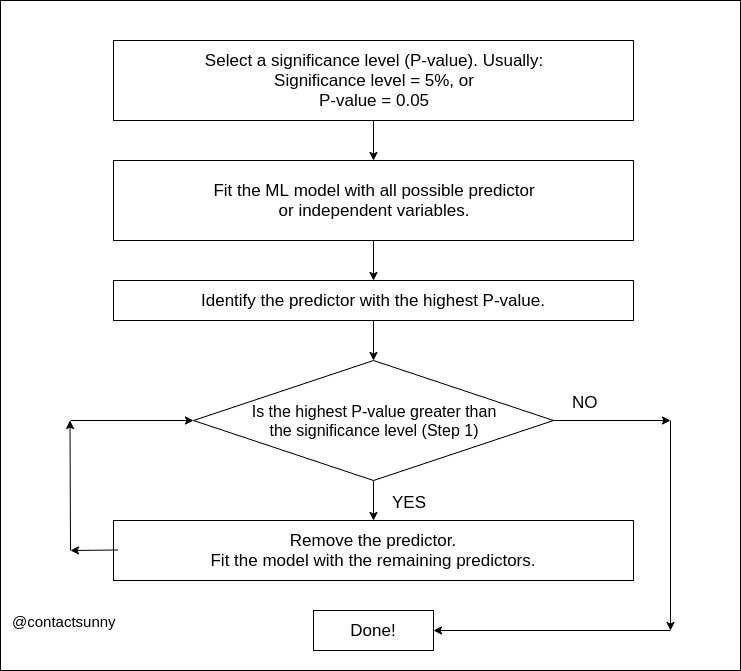

-Picture cited from "https://towardsdatascience.com/backward-elimination-for-feature-selection-in-machine-learning-c6a3a8f8cef4"

In [43]:

import statsmodels.api as sm

def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

x= df_numeric.loc[:, df_numeric.columns != "revenue"].values
Y = df_numeric.loc[:, df_numeric.columns == "revenue"]

SL = 0.1  #significance level

veri_modeled, selected_cols = backwardElimination(x, Y .values,
                                                     SL, selected_columns_1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Convert the result to a dataframe:

In [44]:
result = pd.DataFrame()
result["revenue"] = df_numeric.iloc[:, 5]

In [45]:
data = pd.DataFrame(data = veri_modeled, columns = selected_cols)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

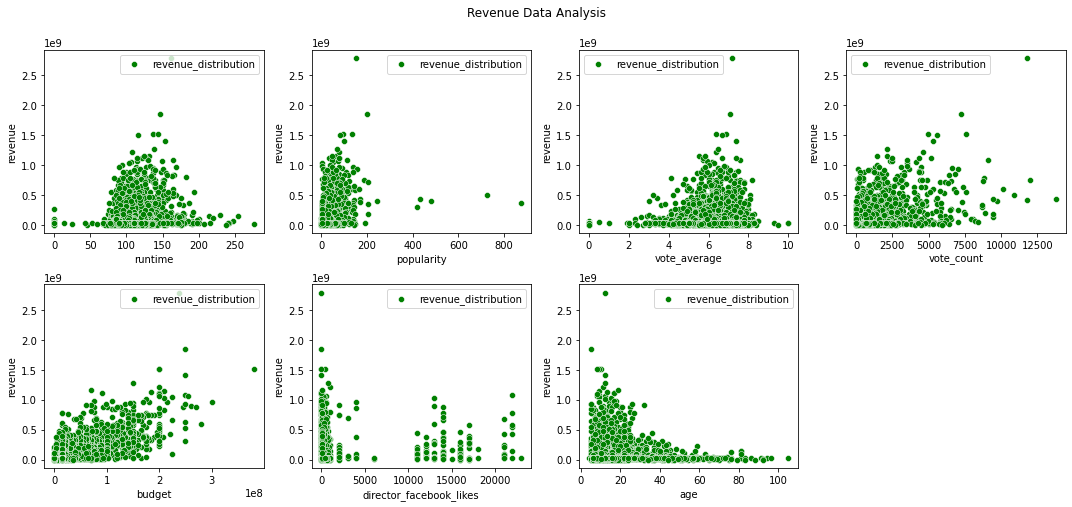

In [46]:
fig = plt.figure(figsize = (15, 20))
j = 0
idx = 0
for i in data.columns:
    plt.subplot(6,4 , j+1)
    j += 1
    sns.scatterplot(data[i], result["revenue"] , color='g', label= "revenue_distribution")
    plt.legend(loc='best')
    plt.xlabel(selected_cols[idx])
    idx += 1
fig.suptitle('Revenue Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show();

In [47]:
elim_cols = []
for i in  df_num.columns:
  if np.issubdtype(df_num[i].dtype, np.number):
    if (i not in selected_cols) & (i != "revenue"):
      print(f"{i} should be deleted from df_nums")
      elim_cols.append(i)

num_voted_users should be deleted from df_nums
actor_3_facebook_likes should be deleted from df_nums
actor_1_facebook_likes should be deleted from df_nums
actor_2_facebook_likes should be deleted from df_nums
cast_total_facebook_likes should be deleted from df_nums
movie_facebook_likes should be deleted from df_nums
imdb_score should be deleted from df_nums
aspect_ratio should be deleted from df_nums


The features that failed to reject our null hypothesis were:


*   actor_2_facebook_likes
*   imdb_score
*   aspect_ratio

So we need to understand the relationship of those guys with our target value. Let's apply some statistical tests to check whether we really should take those values out. 

In [48]:
from scipy.stats import pearsonr, spearmanr

for i in elim_cols:
  coef_pear,p_pear = pearsonr(df_num[i] , df_num["revenue"])
  coef_spear,p_spear = spearmanr(df_num[i], df_num["revenue"])
  print(f"Spearman Correlaton between {i} and revenue is : {round(coef_spear,4)}")
  print(f"The Pearson Correlation between {i} and revenue is: {round(coef_pear,4)}")

Spearman Correlaton between num_voted_users and revenue is : 0.3465
The Pearson Correlation between num_voted_users and revenue is: 0.3101
Spearman Correlaton between actor_3_facebook_likes and revenue is : 0.2042
The Pearson Correlation between actor_3_facebook_likes and revenue is: 0.1704
Spearman Correlaton between actor_1_facebook_likes and revenue is : 0.2371
The Pearson Correlation between actor_1_facebook_likes and revenue is: 0.0934
Spearman Correlaton between actor_2_facebook_likes and revenue is : 0.2305
The Pearson Correlation between actor_2_facebook_likes and revenue is: 0.1584
Spearman Correlaton between cast_total_facebook_likes and revenue is : 0.248
The Pearson Correlation between cast_total_facebook_likes and revenue is: 0.1447
Spearman Correlaton between movie_facebook_likes and revenue is : 0.0748
The Pearson Correlation between movie_facebook_likes and revenue is: 0.2326
Spearman Correlaton between imdb_score and revenue is : 0.0157
The Pearson Correlation between 

We see in here that there is a non-linear correlation with revenue and aspect ratio. So maybe transforming the aspect ratio data might give us sensible results.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

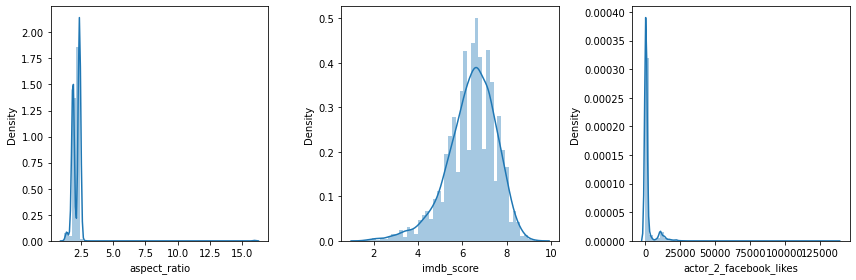

In [49]:

fig, (ax1, ax2, ax3) = plt.subplots(1,3 ,figsize = (12,4))

ax1 = sns.distplot(df_num["aspect_ratio"], ax = ax1);
ax2 = sns.distplot(df_num["imdb_score"], ax = ax2);
ax3 = sns.distplot(df_num["actor_2_facebook_likes"], ax = ax3);
fig.tight_layout()
plt.show()


We see that those two values namely "imdb_scores" and "vote_average" are remarkably similar, so one is redundant for our model. Let's check which one is more correlated by pearson correlation test.

#### Clear the numerical data and take the outliers of:

*   vote_average
*   popularity
*   runtime


#### The spread of the vote_average, popularity and runtime values.

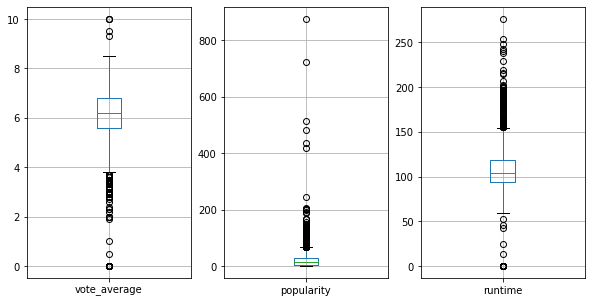

In [50]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(10,5))
ax1 = df_num[["vote_average"]].boxplot(ax =ax1)
ax2 = df_num[["popularity"]].boxplot(ax = ax2)
ax3 = df_num[["runtime"]].boxplot(ax = ax3)

Our popularity values seems OK but in *vote average* and *runtime* values we have some problematic values. 

*   We should keep the runtime values on the upper limit but delete the ones below the lower limit
*   we should delete the outliers of the vote averages.



### More data cleaning of Numerical Values

#### Correlation analysis of:



*   
<font color='green'>*imdb_score*
</font> and <font color='green'>
 *vote_average*
 </font>
*   <font color = 'orange'>*num_voted_users*</font> and
 <font color = 'orange'> *vote_count* </font>

We are going to check the variation between them and if the variation is so small, then we will take out one of them which contributes the least to the target value. So we'll do correlation analysis afterwards.

IMDB scorea nd vote_average

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


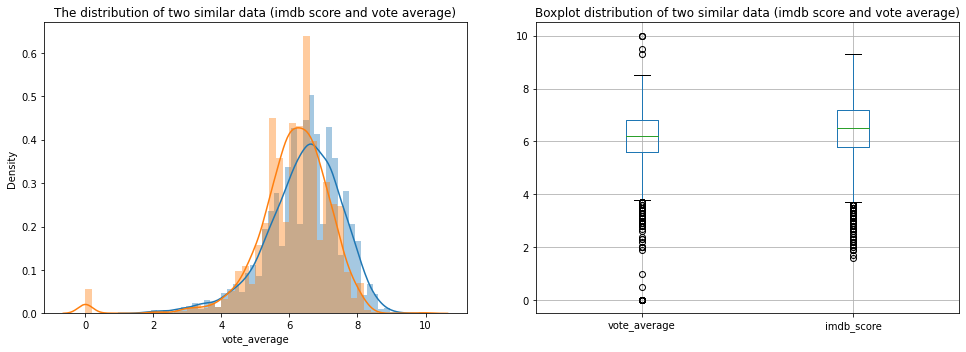

In [51]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1 = sns.distplot(df_num.imdb_score,ax = ax1)
ax1 = sns.distplot(df_num.vote_average,ax=ax1)
ax1.set_title("The distribution of two similar data (imdb score and vote average)")

ax2 = df_num.boxplot(column = ["vote_average", "imdb_score"])
ax2.set_title("Boxplot distribution of two similar data (imdb score and vote average)")
fig.tight_layout()

IMDB score seems to be more normal and includes less outliers in the data, So let's check those two features' relevance with the revenue data before taking out the outliers.


In [52]:
import scipy.stats as stats
sample1 = df_num.vote_average
sample2 = df_num.imdb_score
t_stat, p_val = stats.ttest_ind(sample1, sample2, equal_var=False)
print("Degrees of freedom: 2")
print(f"Our abs value of t stat: {round(abs(t_stat),4) }")

print("Our confidence level is apprx. 99% (from the t-table)")
print("We accept the null hypothesis")

Degrees of freedom: 2
Our abs value of t stat: 12.7108
Our confidence level is apprx. 99% (from the t-table)
We accept the null hypothesis


In [53]:
vote_average = df_num["vote_average"]
imdb = df_num["imdb_score"]
revenue = df_num["revenue"]
coef_1, p_1 = pearsonr(vote_average, revenue)
coef_imdb, p_imdb = pearsonr(imdb, revenue)

if coef_1 > coef_imdb:
  print(f"Coef of imdb with revenue: {round(coef_imdb,4)}")
  print(f"Coef of vote_average with revenue: {round(coef_1,4)}")

  print(f"Coefficient of vote_average is bigger than coefficient of imdb_scores, so imdb_score feature will be deleted.")

Coef of imdb with revenue: 0.049
Coef of vote_average with revenue: 0.1908
Coefficient of vote_average is bigger than coefficient of imdb_scores, so imdb_score feature will be deleted.


In [54]:
corr = df_num[["imdb_score", "vote_average", "revenue"]].corr()
corr

imdb_score  vote_average   revenue
imdb_score      1.000000     -0.002010  0.048961
vote_average   -0.002010      1.000000  0.190765
revenue         0.048961      0.190765  1.000000

Hmmm, we seem to have more correlation with vote_average and revenue, we will check the correlation again after taking out the outliers of the vote_average values (values of 0 and 10 in _vote_average_ data)

This graph is showing that the movies that took more votes seems to have more revenue, so let's test the dependency of the vote_count and revenue values with a independence test.



> Vote_count and num_voted_users

In this case, we have different scaled data. So let's check how to rescale our num_voted_users feature.

In [55]:
print(df_num.num_voted_users.mean())
print(df_num.vote_count.mean())
print(df_num.num_voted_users.mean()/100)

94442.79185098952
726.9045401629802
944.4279185098952


By calculation of means, I decided to divide num_voted_users to 100 to get a better approximate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


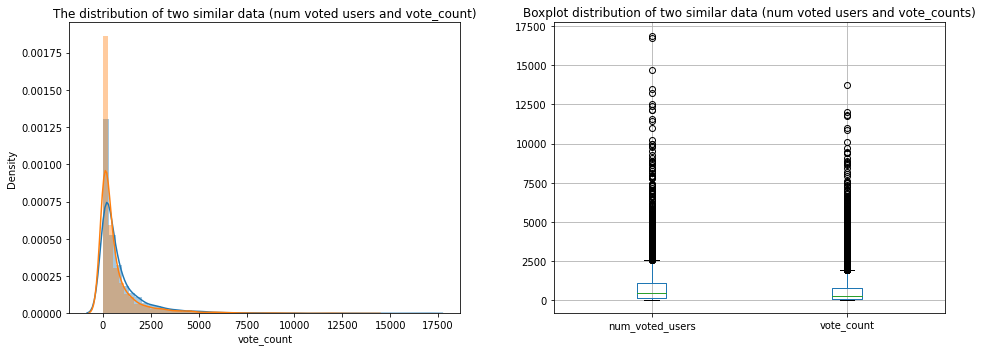

In [56]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1 = sns.distplot(df_num.num_voted_users /100,ax = ax1)
ax1 = sns.distplot(df_num.vote_count,ax=ax1)
ax1.set_title("The distribution of two similar data (num voted users and vote_count)")
ax1.set_label(["df_num_voted", "vote_count"])

df_num["num_voted_users"] = df_num["num_voted_users"] / 100 
ax2 = df_num.boxplot(column = ["num_voted_users", "vote_count"])
ax2.set_title("Boxplot distribution of two similar data (num voted users and vote_counts)")
fig.tight_layout()

We have a more tidy data for vote_count, let's check the correlation between the target:

In [57]:
corr = df_num[["num_voted_users", "vote_count", "revenue"]].corr()
corr

num_voted_users  vote_count   revenue
num_voted_users         1.000000    0.264854  0.310074
vote_count              0.264854    1.000000  0.774492
revenue                 0.310074    0.774492  1.000000

As the revenue is much more correlated with vote_count, we will stick to that.

In [58]:
df_num.drop(columns= "num_voted_users", axis = 0, inplace= True)

We see that correlation between vote_average and revenue is much more bigger than the correlation between imdb_score and revenue. So we will keep the vote_average values for teaching the model.

#### Z score test for outlier detection and removal for vote_average and runtime values.

In [59]:
df_num["votes_z"] = stats.zscore(df_num["vote_average"])

df_num["runtime_z"] = stats.zscore(df_num["runtime"])

df_vote_outliers = df_num.loc[(df_num["votes_z"] > 5) | (df_num["votes_z"] < -5)]

df_runtime_outliers = df_num.loc[(df_num["runtime_z"] > 3) | (df_num["runtime_z"] < -3)]
df_runtime_outliers_2 = df_num.loc[(df_num["runtime_z"] > 3)]

print("No. of outliers in vote_average: ", df_vote_outliers["vote_average"].count())

print("No. of outliers in runtime: (both sides) ",df_runtime_outliers["runtime"].count())
print("No. of outliers in runtime: (only right side) ",df_runtime_outliers_2["runtime"].count())


No. of outliers in vote_average:  48
No. of outliers in runtime: (both sides)  88
No. of outliers in runtime: (only right side)  56


In [60]:
df_num = df_num.loc[(df_num["runtime_z"]> -3)]
df_num = df_num.loc[(df_num["votes_z"]> -4) & (df_num["votes_z"] < 3)]
print("Minimum Average Score: ", df_num.vote_average.min())
print("Maximum Average Score: ", df_num.vote_average.max())

#drop the z_scores columns from the df_num
df_num.drop(columns = ["votes_z", "runtime_z"],inplace = True)


Minimum Average Score:  1.9
Maximum Average Score:  9.3


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Count')

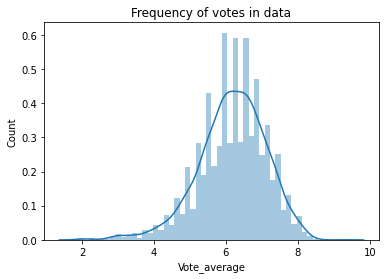

In [61]:
sns.distplot(df_num.vote_average)
plt.title("Frequency of votes in data")
plt.xlabel("Vote_average")
plt.ylabel("Count")




> Now our vote_average data is much less skewed and closer to Gaussian Distribution and which is a thing that we want while we do scaling in our numerical data.


> Having seen that the highest average in the IMDB movies are neaerly 9.3 and smallest average is 1.9 ; I am choosing such points between those by the z-score outlier elimination technique.



#### Let's investigate the relationship between the frequency and average of votes and revenues

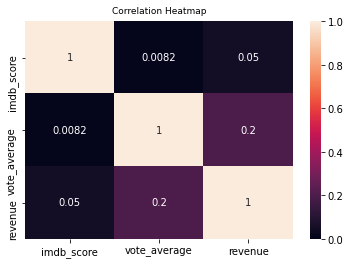

In [62]:
corr_votes = df_num[["imdb_score", "vote_average", "revenue"]].corr()
heatmap = sns.heatmap(corr_votes, vmin=0, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':9}, pad=8);

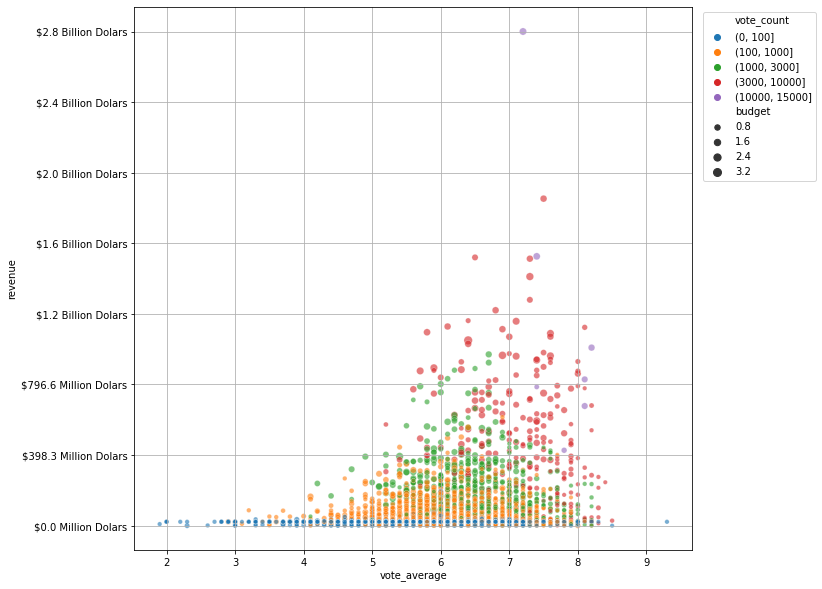

In [63]:
import matplotlib.ticker as mtick


def numfmt(x, pos):
  if x < 1000000000:
    return '$%.1f Million Dolars' % (x/1000000)
  else:
    return '$%.1f Billion Dolars' % (x/1000000000)

rev_data = df_num.revenue
ylocs = np.linspace(0, rev_data.max(), 8)
labels = [f"{value}" for value in ylocs]

yfmt = mtick.FuncFormatter(numfmt)

fig,ax1 = plt.subplots(figsize = (10,10))

hue = pd.cut(df_num.vote_count, [0,100,1000,3000,10000,15000])
ax1 = sns.scatterplot(x = df_num["vote_average"], y = df_num["revenue"],size = df_num["budget"], hue = hue,alpha = 0.6)

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
ax1.set_yticks(ylocs)
ax1.set_yticklabels(labels)
ax1.yaxis.set_major_formatter(yfmt)

plt.grid()
plt.show()


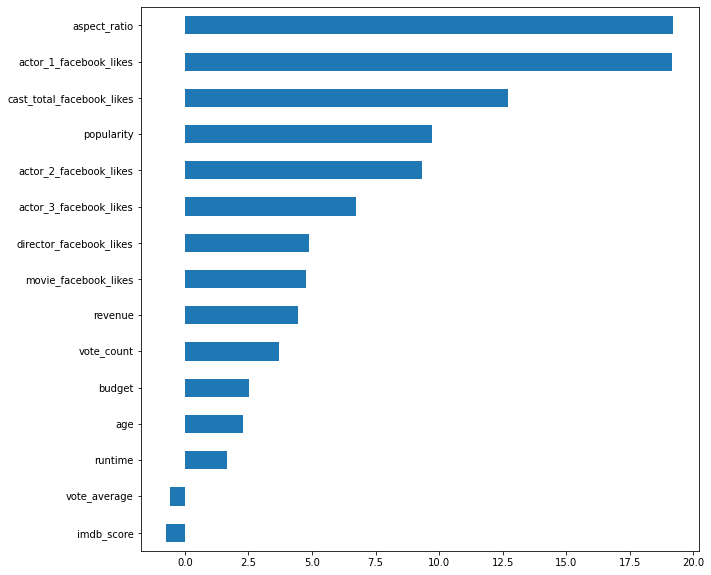

In [64]:
#Observing the skewness of the Data and doing Transformations (if necessary)
num_feats = df_num.dtypes[df_num.dtypes != "object"].index
df_num[num_feats].skew().sort_values(ascending = True).plot.barh(figsize = [10,10])


In [65]:
# del df_num["actor_2_facebook_likes"]
del df_num["cast_total_facebook_likes"]
del df_num["movie_facebook_likes"]

del df_num["actor_3_facebook_likes"]
del df_num["actor_1_facebook_likes"]
del df_num["imdb_score"]
del df_num["aspect_ratio"]

#let's apply some different perpective instead of deleting these features, we will be transforming them to a more normalized distribution.


It looks like we have infitine numbers, let's see how much do we have infinite numbers.

As seen in the above figure, we have transformed our skewed facebook like data with log transformation. One thing to be emphasized in this example is that we have converted those data, but for the following data, we might not have this kind of data, so our model will be effected by this change. Our model will work with the transformed data, thus your next inputs should be transformed to have reliable and solid results.
We will do this after splitting the data, in order to protect the shape of our data.

## Categorical Data Analysis



> Before we dive into the categorical analysis, I want to create a fool_dataframe that contains only the numerical initial features tailored by the EDA, so that we will have more than 1 dataset to check the bias-variance tradeoffs of our models.



In [ ]:

df_fool = df_num[['runtime', 'popularity', 'vote_average', 'vote_count', 'budget',
       'director_facebook_likes', 'actor_2_facebook_likes',
       'age','revenue']]

Boxplots that shows reveue distribution among the most frequent genres and production companies.

#### Organizing the categorical data

Making genre values one hot labeled in order to put them into the model.

Doing  encoding in order to create more numerical variables from categorical attributes for our model. We will evaluate their correlation with the independent variable later.



*   One-hot encoding of Genres
*   Binary encoding of Spoken Language
*   One-hot encoding of (most frequent) keywords
*   Label or binary encoding of countries from 2nd dataset.

We will take out some of those features, in order not to overfit our model, and also for having more accurate results.


We are going to limit the features we choose from the categorical data as we have lots of them and we need to find the optimal feature selection in order not to overfit and to increase our model's accuracy at the same time. So we choose to use one-hot encoding of the categorical values as:


*   Most frequent 50 keywords
*   All 20 genres
*   Most frequent 10 production companies
*   Most frequent 50 actrors or actresses


One hot encoding of keywords:

#### Get recommendations only by the keywords.

If you want to run this cell, run the below cell. If you want to get recommendations by everything, then don't run it, go to next header.

In [ ]:
"""from pandas.io.json import json_normalize
import json

def column_decode(data,key):
    result = []
    for item in data: #convert to list from json
        result.append(item[key])
    return result

df_num.genres = df_num.genres.apply(column_decode,key='name')
df_num.production_companies = df_num.production_companies.apply(column_decode,key='name')
df_num.keywords = df_num.keywords.apply(column_decode,key='name')
df_num.crew = df_num.crew.apply(column_decode, key= "name")
df_num.cast = df_num.cast.apply(column_decode, key= "name")"""

'from pandas.io.json import json_normalize\nimport json\n\ndef column_decode(data,key):\n    result = []\n    for item in data: #convert to list from json\n        result.append(item[key])\n    return result\n\ndf_num.genres = df_num.genres.apply(column_decode,key=\'name\')\ndf_num.production_companies = df_num.production_companies.apply(column_decode,key=\'name\')\ndf_num.keywords = df_num.keywords.apply(column_decode,key=\'name\')\ndf_num.crew = df_num.crew.apply(column_decode, key= "name")\ndf_num.cast = df_num.cast.apply(column_decode, key= "name")'

In [ ]:
def convert_to_str(obj):
  new_item = ""
  for item in obj:
    new_item += item.replace(" ", "-")
  return new_item
# df_num["keywords"].apply(convert_to_str)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
df_num["keywords"] = df_num["keywords"].fillna("")
df_num["keywords"] = df_num["keywords"].apply(convert_to_str)
tfidf_matrix = tfidf.fit_transform(df_num["keywords"].values)

tfidf_matrix.shape

Calculating Cosine Similarity Score

Since we have used TF-Idf vectorizer, the dot product of this matrix will give us the cosine similarity score directly.
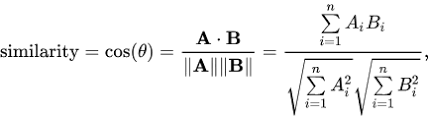

In [ ]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

indices = pd.Series(df_num.index, index=df_num["title"]).drop_duplicates()

def get_recommendations(title, cosine_sim = cosine_sim):
  
  idx = indices[title]

  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse= True)

  #getting the 10 most popular films
  sim_scores =sim_scores[1:11]
  
  movie_indices = [i[0] for i in sim_scores] # each i is a tuple

  return df_num["title"].iloc[movie_indices]


get_recommendations("The Prestige")

#### Genre, keyword, and credits based Recommendation System

In [ ]:
def get_director(x):
  for person in x:
    if person["job"] == "Director":
      return person["name"]
  else:
    return np.nan

def get_list(x):
  if isinstance(x, list):
    names = [i["name"] for i in x]
    if len(names) > 3:
      names = names[:3]
    return names
  else:
    return []

In [ ]:
df_num["director"] = df_num["crew"].apply(get_director)

features = ["cast", "genres","keywords", "production_companies"]
for feat in features:
  df_num[feat] = df_num[feat].apply(get_list)

In [ ]:
df_num[['title', 'cast', 'director', 'keywords', 'genres']].head(3)


The next step is to convert the Upper case letters to lower and to strip all the spaces between the keywords directors and cast because for instance exotic and island could be taken different features, or Johnny Depp and Johnny Cage would be assumed as same person as Johnny's will be the same.

In [ ]:
def clean_data(x):
  if isinstance(x, list):
    return [str.lower(i.replace(" ", ""))  for i in x]
  else:
    if isinstance(x, str):
      x = str.lower(x.replace(" ", ""))
      return x
    else: 
      return ""

In [ ]:
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df_num[feature] = df_num[feature].apply(clean_data)

df_num[features].head(3)

We can now create the metadata soup as all of our data is cleaned and ready to be mixed up. So this metadata soup will contain all the string data we have in one string that we want to feed to our vectorizer.

In [ ]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
df_num["soup"] = df_num.apply(create_soup, axis = 1)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_num["soup"])

from sklearn.metrics.pairwise import cosine_similarity
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)


Reset indexes of our main dataframe and construct index mapping as before

In [ ]:
df_num = df_num.reset_index()
indices = pd.Series(df_num.index, index = df_num["title"])

In [ ]:
def get_recommendations(title, cosine_sim = cosine_sim2):
  
  idx = indices[title]

  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse= True)

  #getting the 10 most popular films
  sim_scores =sim_scores[1:11]
  
  movie_indices = [i[0] for i in sim_scores] # each i is a tuple

  return df_num["title"].iloc[movie_indices]

In [ ]:
get_recommendations("Transcendence", cosine_sim2)

#### Previously Built One Hot Encoding of The columns (Naive Approach)

In [66]:
from pandas.io.json import json_normalize
import json

def column_decode(data,key):
    result = []
    for item in data: #convert to list from json
        result.append(item[key])
    return result

df_num.genres = df_num.genres.apply(column_decode,key='name')
df_num.production_companies = df_num.production_companies.apply(column_decode,key='name')
df_num.keywords = df_num.keywords.apply(column_decode,key='name')
df_num.crew = df_num.crew.apply(column_decode, key= "name")
df_num.cast = df_num.cast.apply(column_decode, key= "name")

In [67]:
keyword_counts = dict()

for item in df_num.keywords:
  for kw in item:
    if kw not in keyword_counts.keys():
      keyword_counts[kw] = 1
    else:
      keyword_counts[kw] += 1


production_counts = dict()

for item in df_num.production_companies:
  for pc in item:
    if pc not in production_counts.keys():
      production_counts[pc] = 1
    else:
      production_counts[pc] += 1

genre_counts = dict()

for item in df_num.genres:
  for genre in item:
    if genre not in genre_counts.keys():
      genre_counts[genre] = 1
    else:
      genre_counts[genre] += 1

cast_counts = dict()

for item in df_num.cast:
  for actor in item:
    if actor not in cast_counts.keys():
      cast_counts[actor]  = 1
    else:
      cast_counts[actor] += 1

crew_counts = dict()

for item in df_num.crew:
  for actor in item:
    if actor not in crew_counts.keys():
      crew_counts[actor]  = 1
    else:
      crew_counts[actor] += 1


In [68]:
#keyword count df
kw_df = pd.DataFrame(keyword_counts.values(),keyword_counts.keys()).sort_values(by = 0,ascending = False)
freqKeyword = kw_df.head(100)
keyword_liste = freqKeyword.head(100).index
#company count df
pc_df = pd.DataFrame(production_counts.values(),production_counts.keys()).sort_values(by = 0,ascending = False)
freqComp = pc_df.head(10)
company_liste = freqComp.index
#genre count df
genre_df = pd.DataFrame(genre_counts.values(), genre_counts.keys()).sort_values(by = 0,ascending = False)
freqgenre = genre_df
genre_liste = genre_df.index
#cast count df
cast_df = pd.DataFrame(cast_counts.values(), cast_counts.keys()).sort_values(by = 0, ascending = False)
freqcast = cast_df.head(100)
cast_liste = freqcast.index
#crew count df
crew_df = pd.DataFrame(crew_counts.values(), crew_counts.keys()).sort_values(by = 0, ascending = False)
freqcrew = crew_df.head(50)
crew_liste = freqcrew.index

In [69]:
count = 0
for cast in df_num.cast:
  for actor in cast_liste:
    if actor in cast:
      count += 1
      break
    else:
      pass

print(f"Ratio of most frequent 50 cast, appearing on the movies data is: {round( count /df_num.shape[0],3)}")

Ratio of most frequent 50 cast, appearing on the movies data is: 0.445


In [70]:
for keyword in keyword_liste:
  one_hot_liste = []
  for row in df_num.keywords:
    one_hot_liste.append(1 if keyword in row else 0)
  
  df_num[keyword] = one_hot_liste

for comp in company_liste:
  one_hot_liste = []
  for row in df_num.production_companies:
    one_hot_liste.append(1 if comp in row else 0)
  
  df_num[comp] = one_hot_liste

for genre in genre_liste:
  one_hot_liste = []
  for row in df_num.genres:
    one_hot_liste.append(1 if genre in row else 0)
  df_num[genre] = one_hot_liste

for cast in cast_liste:
  one_hot_liste = []
  for row in df_num.cast:
    one_hot_liste.append(1 if cast in row else 0)
  df_num[cast] = one_hot_liste

for crew in crew_liste:
  one_hot_liste = []
  for row in df_num.crew:
    one_hot_liste.append(1 if crew in row else 0)
  df_num[crew] = one_hot_liste

In [71]:
df_num.shape

(4222, 297)

    Binary encoding of Language Feature

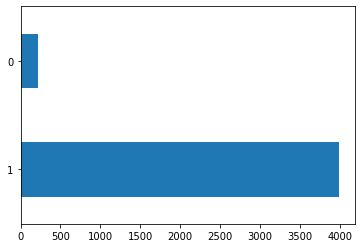

In [72]:
language_binary = np.where(df_num.language == "English", 1, 0)

df_num["isEnglish"] = language_binary

df_num["isEnglish"].value_counts().plot.barh()


In [73]:
df_num.iloc[:5, :7]

title  runtime  ...     budget     revenue
0                                    Avatar    162.0  ...  237000000  2787965087
1  Pirates of the Caribbean: At World's End    169.0  ...  300000000   961000000
2                                   Spectre    148.0  ...  245000000   880674609
3                     The Dark Knight Rises    165.0  ...  250000000  1084939099
5                              Spider-Man 3    139.0  ...  258000000   890871626

[5 rows x 7 columns]

In [74]:
df_num.iloc[:, 124:134]

Metro-Goldwyn-Mayer (MGM)  Touchstone Pictures  ...  Romance  Adventure
0                             0                    0  ...        0          1
1                             0                    0  ...        0          1
2                             0                    0  ...        0          1
3                             0                    0  ...        0          0
5                             0                    0  ...        0          1
...                         ...                  ...  ...      ...        ...
4797                          0                    0  ...        0          0
4799                          0                    0  ...        1          0
4800                          0                    0  ...        1          0
4801                          0                    0  ...        0          0
4802                          0                    0  ...        0          0

[4222 rows x 10 columns]

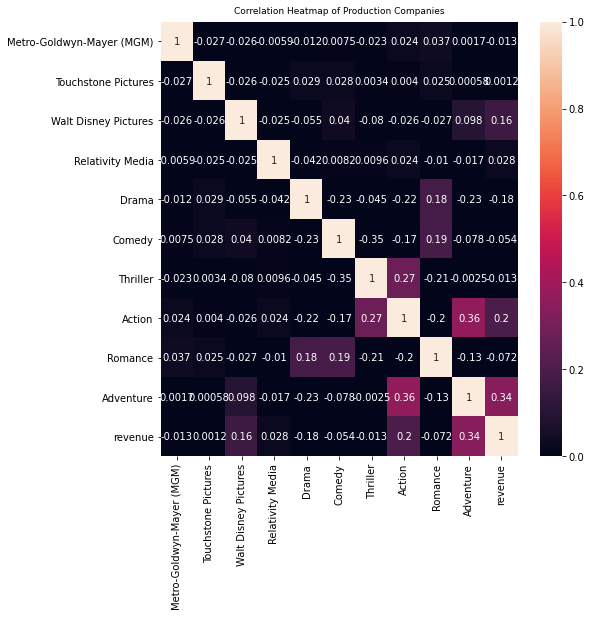

In [75]:
df_comps = df_num.iloc[:, 124:134]
df_comps["revenue"] = df_num["revenue"]
corr_comps = df_comps.corr()
plt.figure(figsize=(8,8))

heatmap = sns.heatmap(corr_comps, vmin=0, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap of Production Companies', fontdict={'fontsize':9}, pad=8);

From this correlation map, we see that Walt Disney, Warner Bros and 20th Century Fox Film Corporation has relatively higher correlation with the target feature "revenue". Considering that those companies are the ones who dominate the film sector, our data is giving us sensible information. But two companies have surprising. The "Universal Pictures" and "Paramount Pictures". I would expect more correlation with revenue from this companies. Let's visualize these relations with a bar graph.

In [76]:
compDict = {x:[0,0,0] for x in df_num.iloc[:, 123:133].columns}

for index, row in df_num.iterrows():
    
    for comp in compDict.keys():

      if row[comp] == 1:
        compDict[comp][0] += row['revenue']
        compDict[comp][1] += 1
        compDict[comp][2] += row['budget']

for key,value in compDict.items():
  value.append(round(value[0] / value[1]))
  value.append(round(value[2] / value[1]))



In [77]:
comp_df = pd.DataFrame(compDict.values(),compDict.keys())
comp_df.columns = ["Total Revenue","Total Movies","Total Budget","Mean Revenue", "Mean Budget"]

comp_df = comp_df.sort_values(by = 'Mean Revenue', ascending = False)

comp_df

Total Revenue  ...  Mean Budget
Walt Disney Pictures         27392003305  ...     84927170
Action                      160067595445  ...     55387613
Relativity Media             12255764786  ...     53567823
New Line Cinema              17982188674  ...     37652219
Touchstone Pictures          10432509673  ...     42615597
Thriller                    104092409421  ...     36299547
Comedy                      127608479649  ...     30515935
Metro-Goldwyn-Mayer (MGM)     9203137398  ...     36147950
Romance                      56390588097  ...     24937298
Drama                       127116395705  ...     25695539

[10 rows x 5 columns]

findfont: Font family ['timesnewroman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['timesnewroman'] not found. Falling back to DejaVu Sans.


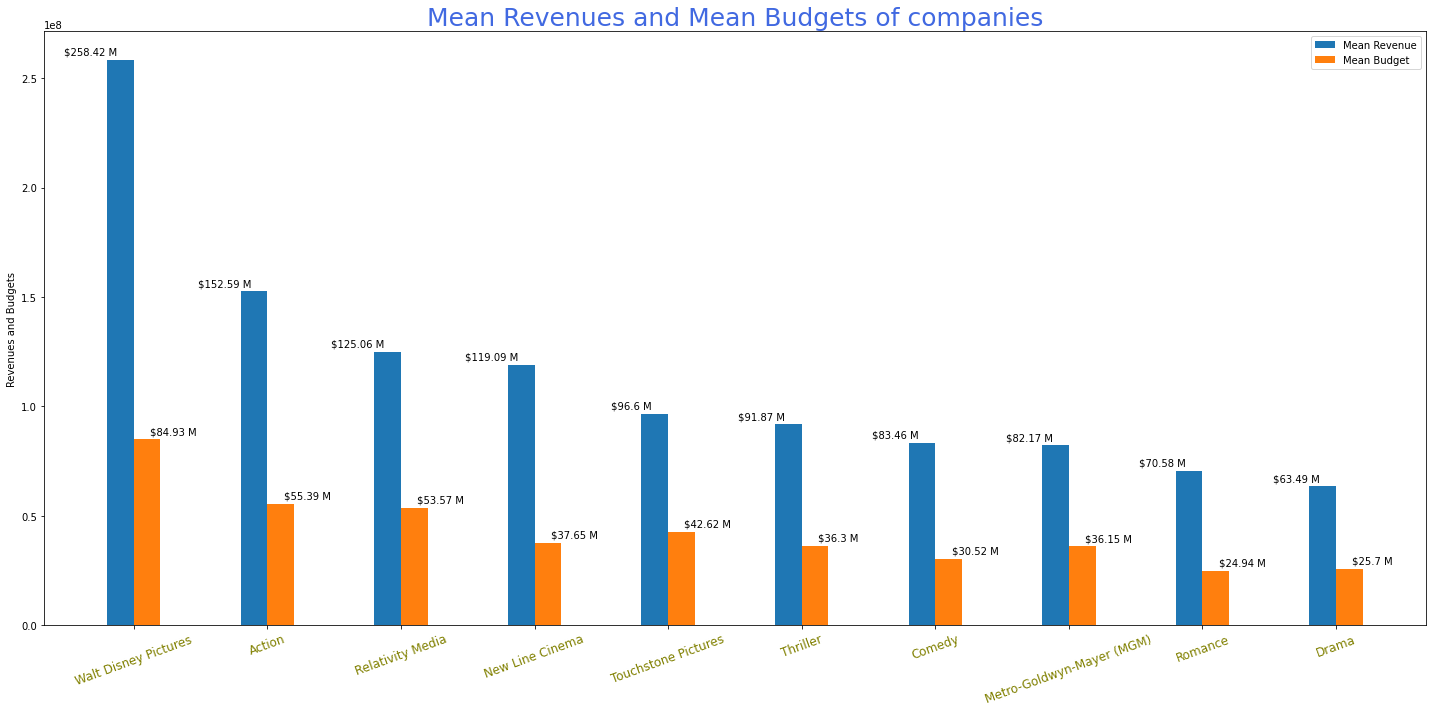

In [78]:

xlabels = comp_df.index
ylocs = np.linspace(0, comp_df['Mean Revenue'].max(), 10)

labels = [f"${round(value/ 100000000)} M" for value in ylocs]

w = 0.02
x = np.arange(0,30,3)
# creating the bar plot 
fig, ax = plt.subplots(figsize = (20,10))

ind = np.arange(10)
width= 0.2

rects1 = ax.bar(ind - width/2, comp_df["Mean Revenue"], width,
                label='Mean Revenue')
rects2 = ax.bar(ind + width/2, comp_df["Mean Budget"], width,
                label='Mean Budget')

font= {'family': 'timesnewroman',
        'color':  'royalblue',
        'weight': 'normal',
        'size': 25,
        }

font_2 = {'family': 'timesnewroman',
        'color':  'olive',
        'weight': 'normal',
        'size': 12,
        }    
  
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Revenues and Budgets')
ax.set_title('Mean Revenues and Mean Budgets of companies', fontdict = font)
ax.set_xticks(ind)
ax.set_xticklabels(comp_df.index, fontdict = font_2, rotation = 20)
ax.legend()


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('${} M'.format(round(height/1000000, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "left")
autolabel(rects2, "right")

fig.tight_layout()


plt.show()

Another significant categorical data we have is our genre data. We have obtained this genre data by multilabel encoding them as binary features -namely one hot encoding-. So let's take a look of the features' correlation with the revenue.

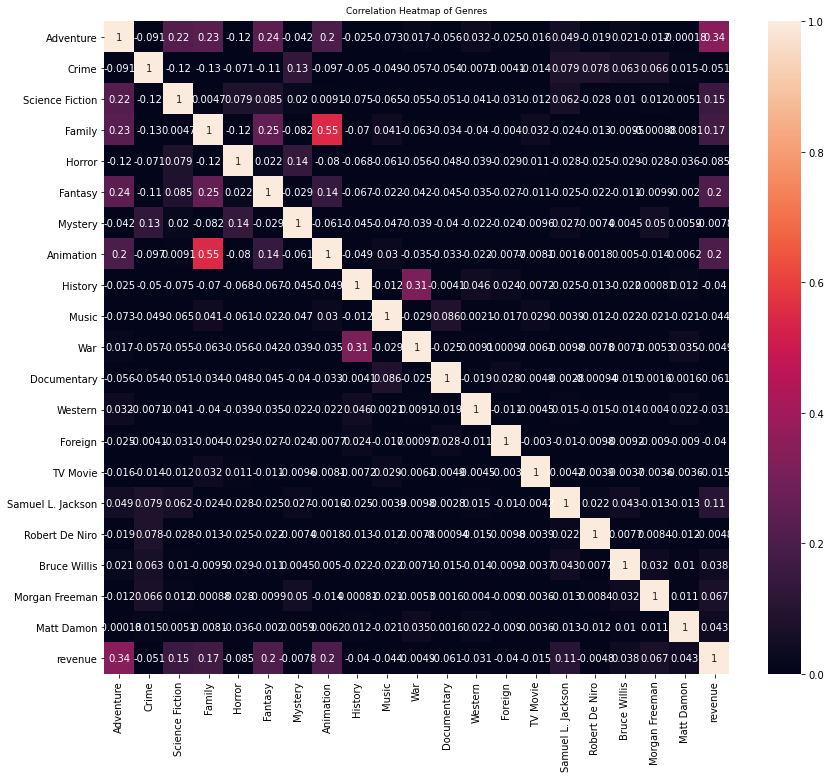

In [79]:
df_genres = df_num.iloc[:, 133:153]
df_genres["revenue"] = df_num["revenue"]
corr_genres = df_genres.corr()
plt.figure(figsize=(14,12))

heatmap = sns.heatmap(corr_genres, vmin=0, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap of Genres', fontdict={'fontsize':9}, pad=8);

The most correlated genre with revenue seems to be Adventure. These correlations are coherent with the statista's data analysis of movie genre and revenue relationship. Adventure followed by Action movies has the lead for the revenue. 

(For statista's website:https://www.statista.com/statistics/188658/movie-genres-in-north-america-by-box-office-revenue-since-1995/)

In [80]:
genreDict = {x:[0,0,0] for x in df_num.iloc[:, 133:153].columns}

for index, row in df_num.iterrows():
    
    for comp in genreDict.keys():

      if row[comp] == 1:
        genreDict[comp][0] += row['revenue']
        genreDict[comp][1] += 1
        genreDict[comp][2] += row['budget']

for key,value in genreDict.items():
  value.append(round(value[0] / value[1]))
  value.append(round(value[2] / value[1]))

genre_df = pd.DataFrame(genreDict.values(),genreDict.keys())
genre_df.columns = ["Total Revenue","Total Movies","Total Budget","Mean Revenue", "Mean Budget"]

genre_df = genre_df.sort_values(by = 'Mean Revenue', ascending = False)

In [81]:
genre_df

Total Revenue  Total Movies  ...  Mean Revenue  Mean Budget
Samuel L. Jackson    14721495092            61  ...     241335985     64360656
Animation            52575359200           220  ...     238978905     69392367
Adventure           161361597914           737  ...     218943823     69308774
Morgan Freeman        9297477679            46  ...     202119080     65206522
Fantasy              78824233255           391  ...     201596504     66972624
Family               82950096687           470  ...     176489567     56285340
Science Fiction      80804558487           485  ...     166607337     56748655
Matt Damon            7499385255            46  ...     163030114     56361472
Bruce Willis          7386028844            48  ...     153875601     57964583
War                  11615593472           128  ...      90746824     38465110
Mystery              27751819359           306  ...      90692220     35476645
Robert De Niro        4773805365            54  ...      88403803     36262963
Crime                46210267822           616  ...      75016669     31580318
History              11314367266           177  ...      63922979     33701317
Music                 9777411039           165  ...      59257037     21110363
Western               3926836203            71  ...      55307552     30950838
Horror               23807433160           441  ...      53985109     19078800
Documentary           2006046012            83  ...      24169229     10165607
TV Movie               110000000             5  ...      22000000     10040000
Foreign                584398144            31  ...      18851553     12334677

[20 rows x 5 columns]

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Courier New'] not found. Falling back to DejaVu Sans.


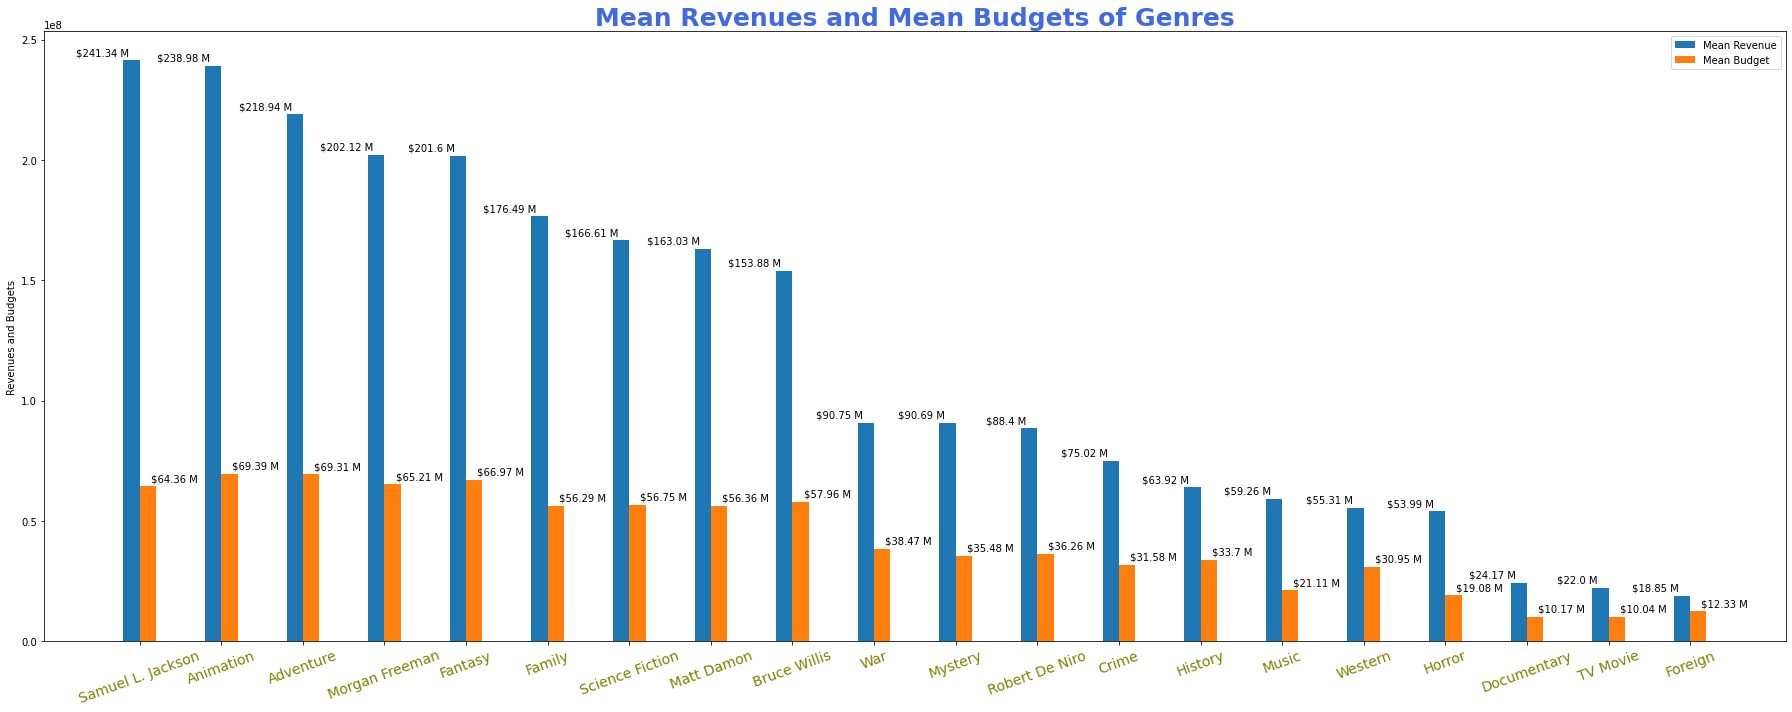

In [82]:

xlabels = genre_df.index
ylocs = np.linspace(0, genre_df['Mean Revenue'].max(), 10)

labels = [f"${round(value/ 100000000)} M" for value in ylocs]

w = 0.02
x = np.arange(0,30,3)
# creating the bar plot 
fig, ax = plt.subplots(figsize = (25,10))

ind = np.arange(20)
width= 0.2

rects1 = ax.bar(ind - width/2, genre_df["Mean Revenue"], width, label='Mean Revenue')
rects2 = ax.bar(ind + width/2, genre_df["Mean Budget"], width, label='Mean Budget')

font= {'family': 'Courier New',
        'color':  'royalblue',
        'weight': 'bold',
        'size': 25,
        }

font_2 = {'family': 'Times New Roman',
        'color':  'olive',
        'weight': 'normal',
        'size': 14,
        }    
  
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Revenues and Budgets')
ax.set_title('Mean Revenues and Mean Budgets of Genres', fontdict = font)
ax.set_xticks(ind)
ax.set_xticklabels(genre_df.index, fontdict = font_2, rotation = 20)
ax.legend()


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('${} M'.format(round(height/1000000, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "left")
autolabel(rects2, "right")

fig.tight_layout()


plt.show()


#### Principal Component Analysis (PCA) of Genre data.

###### eigendecomposition:

It is the process that decomposes a square matrix into eigenvectors and eigenvalues. Eigenvectors are simple unit vectors, and eigenvalues are coefficients which give the magnitude to the eigenvectors. We know that our covariance matrix is symmetrical.ç As it turns out, eigenvectors of symmetric matrices are orthogonal. For PCA this means that we have the first principal component which explains most of the variance. Orthogonal to that is the second principal component, which explains most of the remaining variance. This is repeated fot N number of principal components, Where N equals to number of original features. Principal components are sorted by percentage of variance explained, as we can decide how many should we keep. For example if we have 100 features originally, but the first 3 principal components explain 95% of the variance, then it makes sense to keep only these 3 for visualizations and model training.

In [ ]:
from sklearn.decomposition import PCA
import pandas as pd
pca = PCA().fit(X_genre)
print("Explained variance by component: %s" % pca.explained_variance_ratio_)
nice = pd.DataFrame(pca.components_,columns=genr_cols)

nice.head()

In [ ]:
#plot the decree plot:
plt.figure(dpi = 100, figsize = [10,6])
sns.barplot(x = X_genre.columns,y = pca.explained_variance_ratio_)
plt.xticks(rotation = 60)
plt.title("Explained Variance Ratios of Genres")
plt.text(10 ,0.19, f'Total Explained Variance: {np.rint(np.sum(pca.explained_variance_ratio_))}',
        style='italic',
        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})
plt.text(10 ,0.17, f'Explained Variance of 15 elements: {round(np.sum(pca.explained_variance_ratio_[:15]), 2)}',
        style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.show()

With Principal Component Analysis, this decree plot shows us how much each feature is effecting the total variance of our data. So we can see that the last elements like TV movie and foreign genres explain almost no variation in the data. Looking at the ratios, we calculated that the first 15 genres represent apprx. 97% of the variance. But reducing these 5 columns will not have an effect and as our models like Random Forest and Catboost will automatically do the feature selection, we will not drop any features.

### Statistical analysis of correlance between spoken language and revenue

    H0: feature (spoken language) and target(revenue) are similar
    H1: The feature and the target has significant difference.


In [83]:
x = df_num["isEnglish"]
y = df_num["revenue"]

from scipy.stats import pearsonr

coef, p = pearsonr(x,y)
print(f"The correlation coefficient is: {round(coef,4)}, and the p value is: {round(p,11)}")

The correlation coefficient is: 0.0745, and the p value is: 1.26322e-06


In [84]:
langDict = {"isEng":[0,0,0], "notEng":[0,0,0]}
for index,row in enumerate(df_num.isEnglish):
  if row == 1:
    langDict["isEng"][0] += df_num.revenue.iloc[index]
    langDict["isEng"][1] += df_num.budget.iloc[index]
    langDict["isEng"][2] += 1
  else:
    langDict["notEng"][0] += df_num.revenue.iloc[index]
    langDict["notEng"][1] += df_num.budget.iloc[index]
    langDict["notEng"][2] += 1

for key, value in langDict.items():
  value.append(round(value[0]/value[2])) #mean revenue
  value.append(round(value[1]/value[2]))  # mean budget

lang_df = pd.DataFrame(langDict.values(),langDict.keys())
lang_df.columns = ["Total Revenue","Total Budget", "Counts", "Mean Revenue", "Mean Budget"]



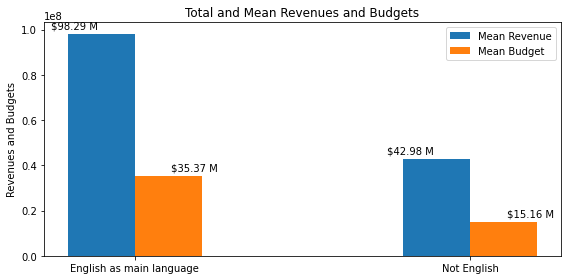

In [85]:
fig, ax = plt.subplots(figsize = (8,4))

ind = np.arange(2)
width= 0.2

rects1 = ax.bar(ind - width/2, lang_df["Mean Revenue"], width,
                label='Mean Revenue')
rects2 = ax.bar(ind + width/2, lang_df["Mean Budget"], width,
                label='Mean Budget')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Revenues and Budgets')
ax.set_title('Total and Mean Revenues and Budgets')
ax.set_xticks(ind)
ax.set_xticklabels(("English as main language", "Not English"))
ax.legend()


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('${} M'.format(round(height/1000000, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "left")
autolabel(rects2, "right")

fig.tight_layout()

plt.show()

As the p-value is smaller than 0.05,  we reject the null hypothesis and can conclude that there is a weak but dependent correlation between those features.

## Machine Learning Models

<font color="purple">
This is the section that you primarily need work on for the final report. Implement at least two machine learning models so that you can compare them.
</font>

We might create two models, one is a regression prediction problems with different models and the other is a classification problem by stratifiying the revenue data. We have chosen to create regression models.

Also we should keep a data that only contains the continuous relative data as our basic model to check the significances of our more complicated model. We will use this dataset to further compare our results with the more complex one.

### Our Target Value is *Revenue*. So we will take it to y before we start to build our machine learning algorithm.

### Implementation

<font color="blue">
Implement and evaluate your models. Perform hyperparameter tunning if necessary. Choose the correct evaluation metrics.
</font>

### Determining Training, Test and Validation Sets:

In [ ]:
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import  LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.max_columns', None)  # Unlimited columns.
pd.options.mode.use_inf_as_na = True        # Any inf or -inf is 
                                            # treated as NA.

This function will help us to see and evaluate our results by giving us both the train set and test set errors. We used RMSE (root mean squared error) for calculating the errors  and we will use r2_score for the performance score.

In [ ]:
results = []
def performance_measures(model, store_results=True):    
    train_rmses = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)
    train_rmses *= -1
    train_mean_rmse = np.mean(train_rmses)
    
    test_rmses = cross_val_score(model, X_test, y_test, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)
    test_rmses *= -1
    test_mean_rmse = np.mean(test_rmses)
    
    r2_scores = cross_val_score(model, X_test, y_test, scoring='r2', cv=3, n_jobs=-1)

    print("Train Mean RMSE: {}\nTest Mean RMSE: {}\
    \nr2_score(avr of 3): {}".format(train_mean_rmse, test_mean_rmse,round(r2_scores.mean(),4)))
    
    if store_results:
        results.append([model.__class__.__name__, train_mean_rmse, test_mean_rmse, r2_scores.mean()])

In [ ]:
df_num = df_num._get_numeric_data()

X = df_num.drop(columns = ["revenue"])
y = df_num["revenue"]

#take the fool dataset
X_f = df_fool.drop(columns = ["revenue"])
y_f = df_fool["revenue"]

In [ ]:
from sklearn.model_selection import train_test_split
#wise one
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
#fool one
foolX_train, foolX_test, fooly_train, fooly_test = train_test_split(X_f, y_f, test_size= 0.2, random_state = 42)

Feature Importances Function

In [ ]:

def plot_feature_importance(model, features_name,model_name):
  
  features = pd.DataFrame(model.coef_, features_name, columns=["coefficient"])
  plt.style.use("tableau-colorblind10")
  #taking the absolute value of coefficients to get rid of negative correlation coefs.
  features.coefficient = features.coefficient.abs()

  stdevs = []
  for i in X.columns:
      stdev = X[i].std()
      stdevs.append(stdev)
      
  features["stdev"] = np.array(stdevs).reshape(-1,1)
  features["importance"] = features["coefficient"] * features["stdev"]
  features['importance_normalized'] = 100* ((features['importance']-features["importance"].min()) /( features['importance'].max() - features['importance'].min()))
  features = features.nlargest(15,columns =["importance_normalized"])
  plt.barh(features.index, features.importance_normalized)
  plt.title(f"Normalized Feature Importances of {model_name}")
  plt.show()


### Linear regression

Wise dataset with 196 different features.

Fool dataset with 11 features


> This so-called "fool" dataset include all the numerical features after the numerical analysis part. This will be considered as our basic data to compare the bias and variance tradeoff by the categorical attributes.



In [ ]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score, mean_squared_error

clf = LinearRegression(n_jobs = -1,normalize = False)
clf.fit(X_train,y_train)
y_pred_linear = clf.predict(X_test)


print("Linear Regression r2_score with category data: ", round(r2_score((y_test),y_pred_linear),4))
print("Linear Regression RMSE with category data: ", (mean_squared_error((y_test),y_pred_linear)))

clf_f = LinearRegression(n_jobs = -1)
clf_f.fit(foolX_train,fooly_train)
y_pred_linear_f = clf_f.predict(foolX_test)

# We are not comparing the results with the fool and wise datasets, we are trying to find out how the residuals were affected,
#and Did the categorical variables hurt the continuous variables.

Linear Regression r2_score with category data:  0.7203
Linear Regression RMSE with category data:  9286326858001964.0


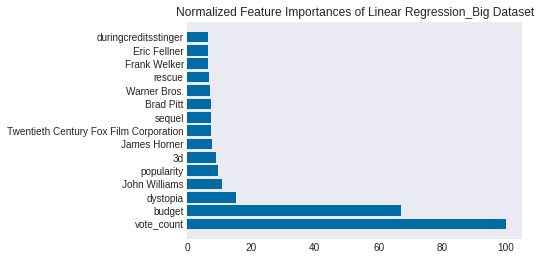

In [ ]:
feature_columns = X_test.columns
plot_feature_importance(clf ,feature_columns, "Linear Regression_Big Dataset")

  When we are taking the coefficients as feature importances, we must assume those are crude importance scores, and also we assume our data is scaled in similar positions.

  Linear machine learning algorithms fit a model where the prediction is the weighted sum of the input values. The "duringcreditsstinger" feature is the most repeated keyword feature encoded as a binary feature, and because of it's weight, our model is generalizing the data. So for this example, our highest coefficient is _"duringcreditsstinger"_ as it creates the weight.

In [ ]:
print(f"Performance measures for Linear Regression with {len(clf.coef_)} features")
performance_measures(clf)

Performance measures for Linear Regression with 1 features
Train Mean RMSE: 92226205.48489825
Test Mean RMSE: 160772030.56234267    
r2_score(avr of 3): 0.218


### Ridge Regression

Wise Dataset Ridge

In [ ]:
ridge_wise = Ridge(alpha = 0.1 ,solver = "auto", normalize = True)
ridge_wise.fit(X_train,y_train)
y_pred_ridge = ridge_wise.predict(X_test)

print(r2_score(y_test, y_pred_ridge))

0.7155606877694513


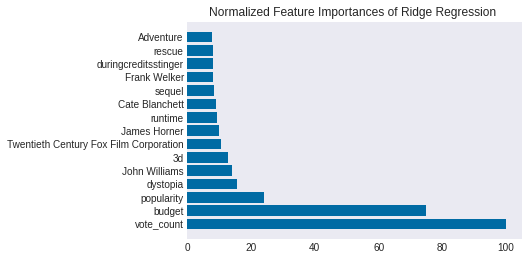

In [ ]:
plot_feature_importance(ridge_wise, feature_columns, "Ridge Regression ")


In [ ]:
from sklearn.metrics import mean_squared_error

performance_measures(ridge_wise)
# print("RMSE of Lasso: ", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print("Total of ",len(ridge_wise.coef_), " features out of" ,len(X.columns), "was taken to account")

Train Mean RMSE: 92207300.03792088
Test Mean RMSE: 157632947.61094776    
r2_score(avr of 3): 0.249
Total of  288  features out of 288 was taken to account


### Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

a = 0.01

lassoCV = Lasso( alpha = a,tol = 0.001, max_iter = 100, normalize = False).fit(X_train, y_train);
y_pred_lasso_CV = lassoCV.predict(X_test);

print(f"Lasso regression with {len([lassoCV.coef_!= 0])} features out of {len(X_test.columns)}")

performance_measures(lassoCV);

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.550049320900452e+18, tolerance: 8.874006925441221e+16
  positive)


Lasso regression with 1 features out of 288
Train Mean RMSE: 92228736.28271747
Test Mean RMSE: 161042720.21560523    
r2_score(avr of 3): 0.2156


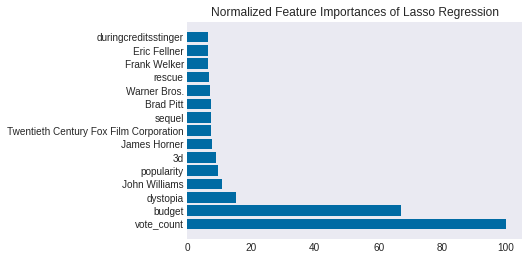

In [ ]:
plot_feature_importance(lassoCV, feature_columns, "Lasso Regression")

Both the Linear and Ridge regression gave a remarkable result on interpreting the training data, but looking at the Test RMSE, the results have changed dramatically. So we can conclude that Linear regression has a very large bias although relatively low variance. When the dataset changes, the linear regression could not adapt to the situation. Whereas Ridge Regression gave 109M. We will use the result of Ridge Regression to further evaluate the results.

### KNN regressor

KNN algorithm is a distance based supervised machine learning algorithm. We are planning to use euclidean distance, but we can use cosine distance for the binary variables. We will be splitting our model data into two;
- in the first KNN we will calculate the cosine similarity distance of the variables,
- and in the other, we will be using euclidean distance for continuous numbers.

Then we will merge these models with the VotingRegressor 

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaler_y = MinMaxScaler()
y_train_res = y_train.values.reshape(-1,1)

scores_kneighbor = []
for n in range(25, 201, 25):
  model = KNeighborsRegressor(n_neighbors = n, algorithm = "auto", leaf_size = 50)
  # fit model
  X_train_trans = scaler.fit_transform(X_train)
  X_test_trans = scaler.transform(X_test)
  model.fit(X_train_trans, y_train)
  # make a prediction
  yhat = model.predict(X_test_trans)
  #inverse transform the predicted yhat values
  #append score to scores:
  scores_kneighbor.append(r2_score(y_test,yhat))
  # summarize prediction
  print(f"r2 score of {n}-neighbor regressor: ",round(r2_score(y_test,yhat),4))
  

r2 score of 25-neighbor regressor:  0.1536
r2 score of 50-neighbor regressor:  0.1055
r2 score of 75-neighbor regressor:  0.0663
r2 score of 100-neighbor regressor:  0.05
r2 score of 125-neighbor regressor:  0.0368
r2 score of 150-neighbor regressor:  0.0232
r2 score of 175-neighbor regressor:  0.0134
r2 score of 200-neighbor regressor:  0.0042


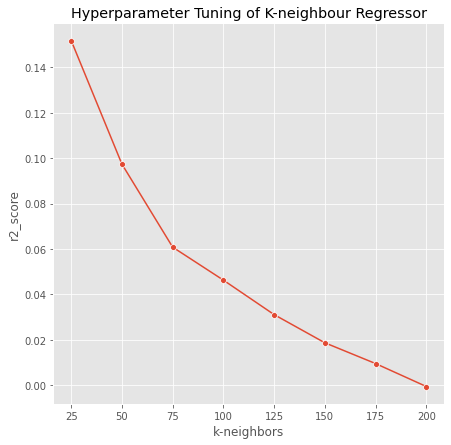

In [ ]:
fig, ax = plt.subplots(figsize = (7,7))

x = np.linspace(25,200,8)
ax = sns.lineplot(x = x, y = scores_kneighbor, markers= True, marker = "o")
ax.set_title("Hyperparameter Tuning of K-neighbour Regressor")
ax.set_xlabel("k-neighbors")
ax.set_ylabel("r2_score")
ax.grid(True)

We will pick 75 in this case for the KNNRegressor Algorithm as it has given the highest r2_score for us.

In [ ]:
from sklearn.model_selection import GridSearchCV

#transform the data.
y_cont = y #no difference
X_cont = X.iloc[:, :13]
knn_features = X_cont.columns
X_bin = X.iloc[:, 13:]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_cont, y_cont, test_size = 0.2, random_state = 3)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_bin, y, test_size = 0.2, random_state = 3)

#apply transformation to the continuous data
cont_scaler = MinMaxScaler()
cont_yscaler = MinMaxScaler()

X_train2 = cont_scaler.fit_transform(X_train2)
X_test2 = cont_scaler.transform(X_test2)

y_train2 = cont_yscaler.fit_transform(y_train2.values.reshape(-1,1))
y_test2 = cont_yscaler.transform(y_test2.values.reshape(-1,1))


knn_cont = KNeighborsRegressor(n_neighbors =30, p = 1)
#{'n_neighbors': 20, 'p': 1} RMSE: 0.0496348331455812
"""
grid = GridSearchCV(knn_cont,param_grid = {
                    "n_neighbors":[20,30,50,100,200,500],
                    "p":[0,1,2],
                }, 
             cv = 5, n_jobs = -1, scoring = "neg_root_mean_squared_error")

grid.fit(X_train2, y_train2)
print(grid.best_params_)
print(-grid.best_score_)"""

# fit model
knn_cont.fit(X_train2, y_train2)
# make a prediction
yhat_trans = knn_cont.predict(X_test2)

yhat = cont_yscaler.inverse_transform(yhat_trans)
print("RMSE: ",np.sqrt(mean_squared_error(yhat, y_test2)))

RMSE:  132083112.1325217


In [ ]:
performance_measures(knn_cont)

Train Mean RMSE: 110709838.33346385
Test Mean RMSE: 122985187.0637572    
r2_score(avr of 3): 0.5437



Why we use cross validation ?


> We use cross validation to reduce the overfit of our model by checking different data from our dataset. We take different data by sparsing the data to given amount, and it checks whether our results give similar results, or give a strong result by coincidence. It helps us to recognize whether we have received the data by chance, or by the sense of data. We realize that it is decreasing our metrics of r2_score and RMSE, but we do not want a model that easily detect this dataset, we want a model that can communicate and understand relationships with other movie datasets like this.



### Random Forest Regressor by Grid Search and K-fold Cross Validation

The hyperparameters will be optimized for our dataset:

*  max_depth
*  n_estimators
*  max_features 

setting up those hyperparameters helps us for both having good results and not overfitting the training data.

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy


In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestRegressor

def rfr_model(X, y):
    
    #creating the random forest model (5 fold cross_Validated, fine tuned)
    rfr = RandomForestRegressor(max_depth=100 ,max_features = 100, n_estimators=40, random_state=1, verbose=False)
  # Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=5, scoring='neg_root_mean_squared_error')
    predictions = cross_val_predict(rfr, X, y, cv=5)
    rfr.fit(X, y)
    names = X.columns
    features = sorted(zip(map(lambda x: round(x, 4), rfr.feature_importances_[:15]), names), 
             reverse=True)


    return scores, predictions, features, rfr
scores, y_pred, features, rfr = rfr_model(X_train, y_train)

performance_measures(rfr)

Train Mean RMSE: 80596948.68682928
Test Mean RMSE: 100528025.68893301    
r2_score(avr of 3): 0.6948


In [ ]:
print("RMSE of Random Forest Model: ",abs(scores.mean()))

RMSE of Random Forest Model:  77763334.38642618


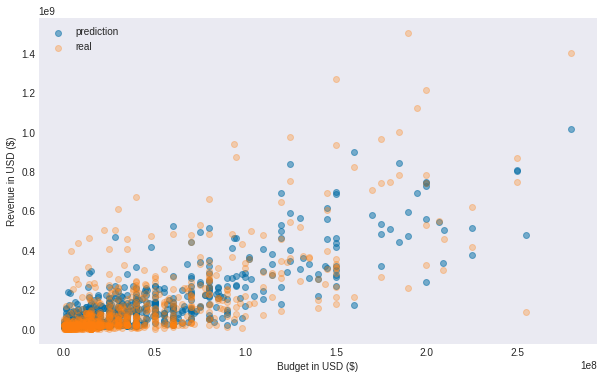

In [ ]:
y_predictions = rfr.predict(X_test)
plt.figure(figsize= [10,6])
plt.scatter(X_test["budget"], y_predictions, alpha = 0.5, label = "prediction")
plt.scatter(X_test["budget"], y_test, alpha = 0.3, label = "real")
plt.xlabel("Budget in USD ($)")
plt.ylabel("Revenue in USD ($)")
plt.legend()
plt.show()

Our RMSE has decreased significantly according to our 30-Nearest Neighbor Model. So Random Forest gives better results for this reason. We should also compare the goodness of fit with the linear and ridge regression models. This is the best result so far.

In decision trees, every node is a condition of how to split values in a single feature, so that similar values of the dependent variable end up in the same set after the split. The condition is based on impurity, which in case of classification problems is Gini impurity/information gain (entropy), while for regression trees its variance. So when training a tree we can compute how much each feature contributes to decreasing the weighted impurity.
Pros:
* fast calculation, easy to retrieve
Cons:
* biased approach, as it has a tendency to inflate the importance of continuous features or high-cardinality categorical variables

_Lewinson, Eryk. “Explaining Feature Importance by Example of a Random Forest.” Medium, Towards Data Science, 17 Apr. 2020, towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e._


Text(0.5, 1.0, 'Feature Importances of Random Forest Regression after Bagging and GridSearch')

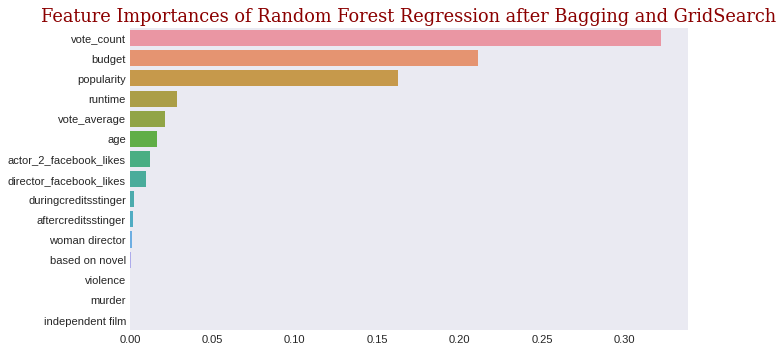

In [ ]:
corrs = [features[i][0] for i in range(len(features))]
labels = [features[i][1] for i in range(len(features))]

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

fig = plt.subplots(figsize= (9,5), dpi = 80)
sns.barplot(x = corrs, y = labels)
plt.title("Feature Importances of Random Forest Regression after Bagging and GridSearch", fontdict=font)


In [ ]:
!pip install rfpimp

  Created wheel for rfpimp: filename=rfpimp-1.3.7-cp36-none-any.whl size=10670 sha256=ead543547fd1c44ee01e8bab6e46d489cb430322513bfd89582d533e80467475
  Stored in directory: /root/.cache/pip/wheels/16/08/23/9d90df482c9c943df4d6fe874c0937f8e81dc3db917c9300c2
Successfully built rfpimp


In [ ]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rfr, X_train, y_train):
    return r2_score(y_train, rfr.predict(X_train))

perm_imp_rfpimp = permutation_importances(rfr, X_train, y_train, r2)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


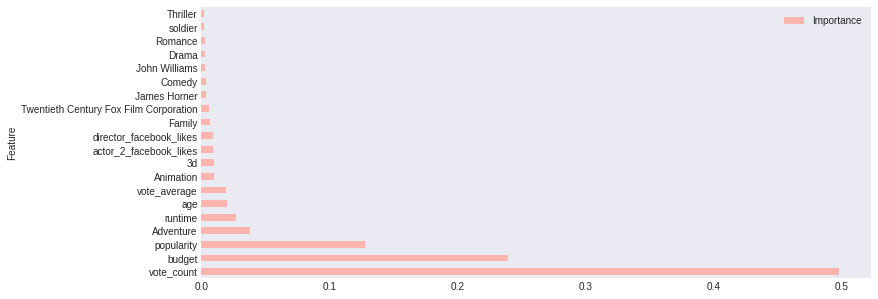

In [ ]:
from matplotlib import cm
import matplotlib.colors as mcolors

perm_imp_rfpimp.sort_values(by = "Importance", ascending = False).head(20).plot.barh(figsize = [12,5],cmap = "Pastel1", )

Remember, we had seen that in Linear Regression the runtime and vote average was the features that decreased the model accuracy, whereas in Random Forest model, it seems that they are contributing to our model. If we had taken out those features, our RFR model would affect negatively. And also we would be overfitting by the vote_count as it is the most effective feature while calculating the importance scores.

The first feature importance of random forest was using impurity based feature selection. And impurity based feature selections are strongly biased towards the continuous data over low cardinality features (like binary data). This permutation scores do not exhibit such bias.

### Catboost Model

Let's use another algorithm called Catboost. It is an algorithm that was made by the best data engineers and software developers in Yandex, and it works thoroughly at the first run without making any hyperparameter tuning examples. It is learning by itself and gives us very clear results. It is being applied in different sectors like HyperLocal Forecast and Movie Recommendation, so we thought, why not using it to estimate the Movie Prices ? 

In [ ]:
!pip install catboost

     |████████████████████████████████| 65.8MB 71kB/s 


In [ ]:
import catboost as ctb
from catboost import Pool

catmodel = ctb.CatBoostRegressor(iterations=3000, 
                                 learning_rate=0.02, 
                                 depth=5, 
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.8,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=1000,
                                 penalties_coefficient = 1,
                                 random_seed=42)

catmodel.fit(X_train, y_train)
y_pred_cat = catmodel.predict(X_test)

r2_score(y_test, y_pred_cat)


CatBoost is based on gradient boosted decision trees. During training, a set of decision trees is built consecutively. Each successive tree is built with reduced loss compared to the previous trees.

The number of trees is controlled by the starting parameters. To prevent overfitting, use the overfitting detector. When it is triggered, trees stop being built.

In [ ]:
performance_measures(catmodel, store_results = True)

Train Mean RMSE: 75694052.96119201
Test Mean RMSE: 100001242.22805633    
r2_score(avr of 3): 0.6967


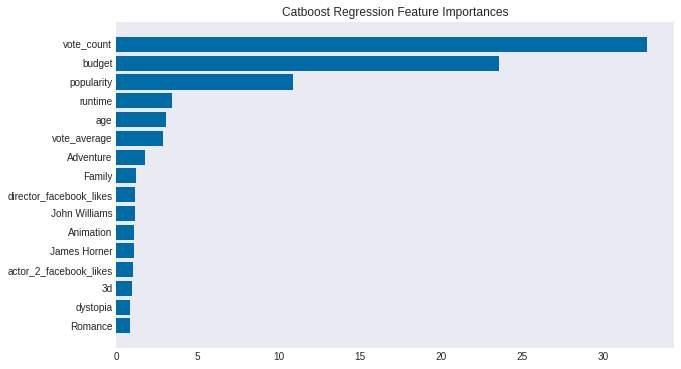

In [ ]:
pool = Pool(X_test, y_test)
training_pool = Pool(X_train, y_train)
cat_importances = catmodel.get_feature_importance()
imp = list(cat_importances)
imp = np.array(imp)
imp = np.reshape(imp, (-1,1))

plt.figure(figsize = [10,6])
df_imp = pd.DataFrame(imp, index = feature_columns, columns = ["importances"])
df_imp = df_imp.sort_values(by = ["importances"], ascending = False)[15::-1]
plt.barh(width = df_imp.importances ,y= df_imp.index)
plt.title("Catboost Regression Feature Importances")
plt.show()

### XGBoost Regressor

This algorithm is basically a mix of all of the techniques we have used on top, decision trees, data pruning, random forest, bagging, boosting, gradient boosting, nan handling.

In [ ]:
pip install xgboost

In [ ]:
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

xgb_rf =XGBRFRegressor(max_depth = 10,reg_alpha = 0.5,n_estimators = 150,learning_rate = 1, gamma = 1,reg_lambda = 1,n_jobs = -1)

"""grid = {"learning_rate": [1,0.5,0.1,0.05],  #learning rate of the optimization function.
        "reg_alpha":[0.5,1,3,5, 10], #Penalizes the features by increasing the cost function
        "reg_lambda":[1, 2, 3],   #l2 regularization penalty term on cost function
        "n_estimators":[50,100],  #number of trees created
        "gamma": [0.001, 0.0001]} #minimum loss reduction required to make further partition on the branches.
grid_xgb = GridSearchCV(xgb_rf, param_grid = grid, cv = 3, scoring = "neg_root_mean_squared_error")

grid_xgb.fit(X_train, y_train)
print(grid_xgb.best_score_)
print(grid_xgb.best_params_)"""
#result of xgboost grid search: -85500353.5638541
#{'gamma': 0.001, 'learning_rate': 1, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 1}

xgb_rf.fit(X_train, y_train)
xgbrf_tahmin = xgb_rf.predict(X_test)
print("Mean Absolute Error RF : " + str(mean_absolute_error(y_test, xgbrf_tahmin)))
print("Root Mean Squared Error RF: "+str(np.sqrt(mean_squared_error(y_test, xgbrf_tahmin))))

[16:15:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error RF : 43219930.55443787
Root Mean Squared Error RF: 88066300.87950909


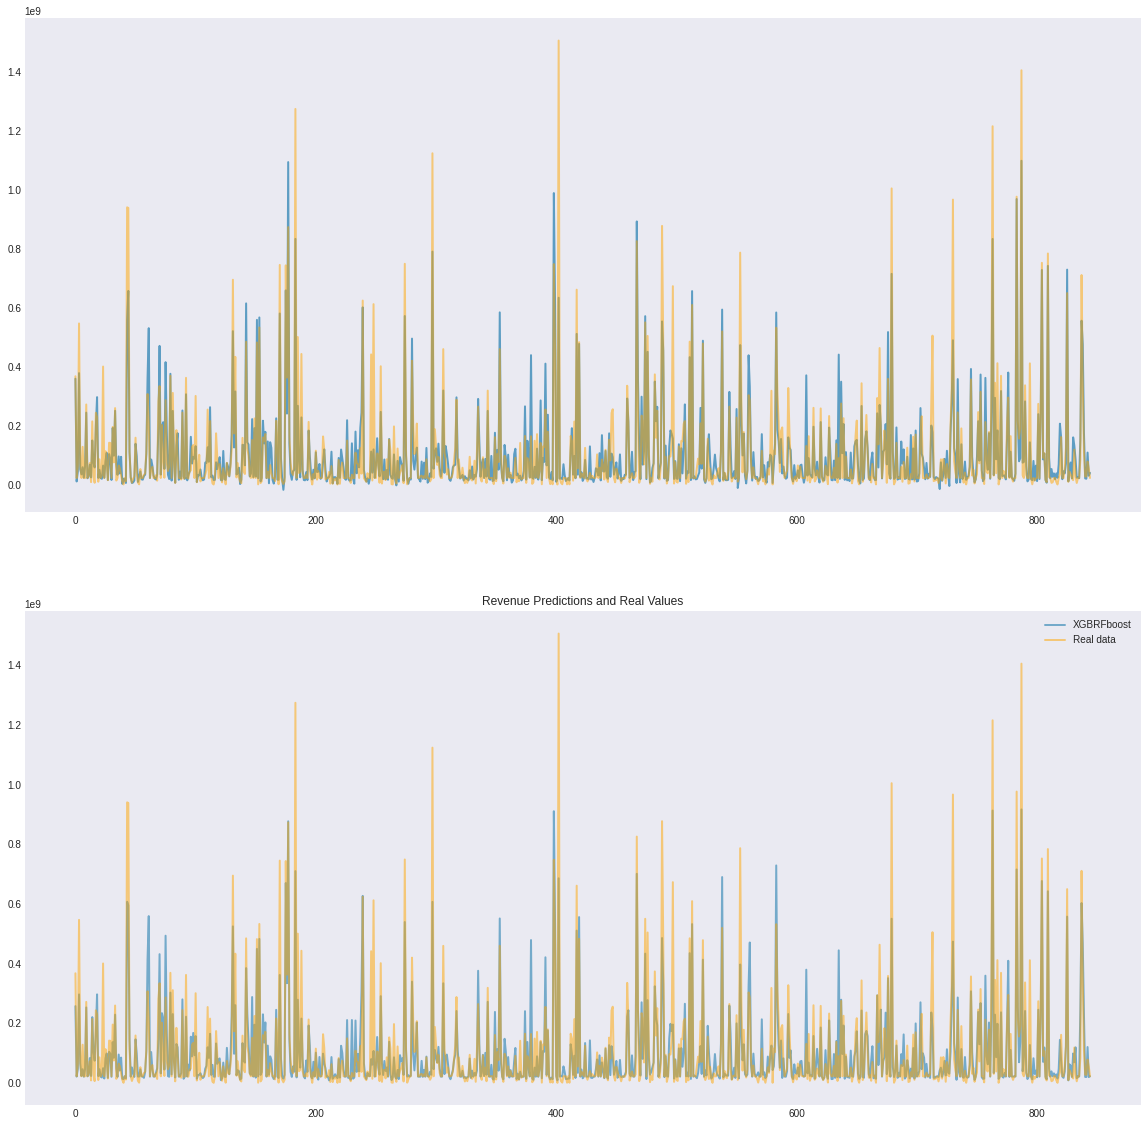

In [ ]:
fig,axs = plt.subplots(2,1,figsize = [20,20])
xaxis = [i for i in range(len(y_test))]
axs[0].plot(xaxis, y_pred_cat, label = "Catboost", alpha = 0.6, linewidth = 2)
axs[1].plot(xaxis, xgbrf_tahmin, label = "XGBRFboost", alpha = 0.5,linewidth = 2)
axs[0].plot(xaxis, y_test,label =  "Real data", alpha = 0.5, linewidth = 2,color = "orange")
axs[1].plot(xaxis, y_test,label =  "Real data", alpha = 0.5, linewidth = 2, color = "orange")

plt.legend()
plt.title("Revenue Predictions and Real Values")
plt.show()


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

df_num['prediction'] = xgb.predict(X)
df_num['prediction2'] = catmodel.predict(X)

df_num['residual'] = df_num['prediction'] - df_num["revenue"]
df_num['residual2'] = df_num['prediction'] - df_num["revenue"]


fig = px.scatter( x='prediction', y='residual',data_frame=df_num,
    marginal_y='violin', trendline='ols',color = "budget",title = "The Residual plot of XGBoost Random Forest Predictions"
)
fig.show()

fig = px.scatter( x= "prediction2", y= "residual2", data_frame=df_num,
                 marginal_y='violin',trendline="ols",color = "budget", title="The Residual Plot of Catboost Regression")
fig.show()

In [ ]:
results_df

0           1             2            3
0             NaN         NaN  3.588914e+08  257125872.0
1             NaN         NaN  1.028022e+07   21049978.0
2             NaN         NaN  4.457871e+07   46977952.0
3             NaN         NaN  3.778421e+08  296472416.0
4             NaN         NaN  5.163601e+07   64763876.0
..            ...         ...           ...          ...
840           NaN         NaN  2.068561e+07   19758566.0
841 -5.547262e+07 -55363158.0  1.952738e+07   19636842.0
842           NaN         NaN  1.082823e+08  120030544.0
843 -3.859938e+07 -49041148.0  2.966848e+07   19226714.0
844           NaN         NaN  3.931889e+07   21994568.0

[845 rows x 4 columns]

In [ ]:
performance_measures(xgb)

Train Mean RMSE: 110144605.21499993
Test Mean RMSE: 128935234.85351895    
r2_score(avr of 3): 0.4949


In [ ]:
performance_measures(xgb_rf)

Train Mean RMSE: 91701916.9849786
Test Mean RMSE: 104652781.20743932    
r2_score(avr of 3): 0.6692


### Results & Discussion

<font color="blue">
Display and discuss the results of your models. Deploy tables, figures etc. to present your results. Discuss the advantages/disadvantages of models compared to each other.
</font>


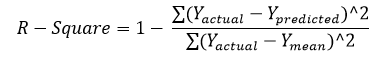
```

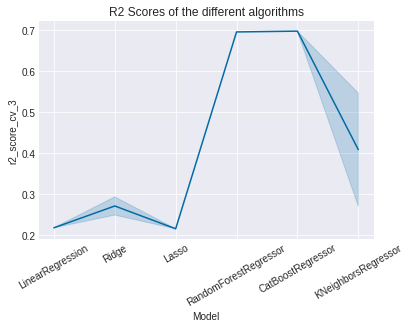

In [ ]:
res = pd.DataFrame(results,columns=["Model", "Train RMSE", "Test RMSE", "r2_score_cv_3"])

sns.lineplot(x = res["Model"], y = res["r2_score_cv_3"], dashes = True, markers = "x")
plt.xticks(rotation = 30)
plt.grid(True)
plt.title("R2 Scores of the different algorithms")
plt.show()

What we should know!


> R-squared is a goodness of fit measure for the regression models and it accurately reflects the precentage of the dependent variable variation that the linear model explains.
> A low r^2 is not always the problem and it does not automatically indicate we have a good model, we should investigate the RMSE 


Our observations from this graph:



*   Our first observation would be that the Ridge's r2 score is bigger than Lasso's regression. In Lasso model, we are using a different calculation of shrinkage function -which takes the absolute values of the parameters- and which results some of them to become zero, so it eliminates some features and reduces sparsity, this is a good way of reducing bias but it came with a result, and it was that it decreased the r2_score according to ridge.
*   Our worst r2_valued model is KNeighbors Regressor model. When thinking the way our algorithm works, it checks the distance of closest 75 neigbors and decides a number, therefore it usually does focus on decreasing the variation.
*   We have used an ensemble model called Random Forest Regression and compared with the simple decision trees, RFR runs efficiently on high-dimensional data sets, and it is more accurate and robust to noise. So it has less variance compared to Ridge and Lasso
*   In this variability case, Catboost algorithm seems to be the winner for this challenge which is another boosting algorithm. It has minimized the variance relationship of the dependent variables for the independent variables but we should also check the Residual Error Plots to see whether this model is overfitting or not.



#### Knowledge is gained, but in what loss?

#### Residual Plots of the Different Models

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

df_num['prediction'] = ridge_wise.predict(X)

df_num['residual'] = df_num['prediction'] - df_num["revenue"]


fig = px.scatter( x='prediction', y='residual',data_frame=df_num,
    marginal_y='violin', trendline='ols',title = "The Residual plot of ridge Regression"
)
fig.show()


Looking at the Ridge Regression residual plot, our first observation is:
-  There seems to be no correlation between the residuals and their homoscedasticity might seem to be increasing but it is OK for this plot because it is not that much significant. Actually it helps us to understand one thing.
- Smaller Revenue predictions has less variance of residuals, which means we are making more valid predictions for smaller revenue, and this is quite expected as the number of movies for the medium revenues is the majority of our data.
- As this is a type of linear regression model, our model cannot estimate the higher values that well lack of data and algorithm complexity, so it is _underfitting_ in this case for our bigger revenued movies. In order to fix this we used more complex models.
- From the violinplot although it looks like we have a similar distribution of overestimation and underestimation, our underestimations do have bigger error size.


##### Hypothesis Tests for checking Normality, Homogeneity, Stationarity

Normality Assumption


> H0: The test follows normal distribution (composite meaning: Expected skewness:0, expected kurtosis = 3)

> H1: The test does not follow normal distribution



In [ ]:
import statsmodels.api as sm
from scipy.stats import jarque_bera, shapiro

coef_jarq, p_jarq = jarque_bera(df_num["residual"])
coef_shap, p_shap = shapiro(df_num["residual"])
print("p-value of Jarque-bera test is: ", p_jarq)
print("p-value of Shapiro-Wilk test is : ", p_shap)

p-value of Jarque-bera test is:  0.0
p-value of Shapiro-Wilk test is :  0.0


> The reason why those tests rejected the null hypothesis is because the probability density of our graph's mean is so small that it does not fit the normal distribution, but overall curve of the violinplot clearly suggests that the residuals are normally distributed.

Homogeneity Assumption
> H0: The test is homoscedastic

> H1: The test is heteroscedastic

In [ ]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.stats.diagnostic import het_white,het_breuschpagan, het_goldfeldquandt

test_1 = sms.het_breuschpagan(df_num["residual"],X)
print("breusch-pagan test p_value: ", test_1[1])


breusch-pagan test p_value:  1.3891545967996983e-244


In [ ]:
test_2 = sms.het_goldfeldquandt(df_num["residual"], X)
print("goldfeldquandt test p value: ", test_2[1])

goldfeldquandt test p value:  0.9999999999999999


Stationarity Assumption:

> N0: There is autocorrelation in residuals.

> N1: There is no autocorrelation in residuals.

If there is autocorrelation between the residuals, it is a bad sign as autocorrelation refers to the degree of correlation between the values of the same variables across different observations in the data. In a regression analysis, autocorrelation of the regression residuals can also occur if the model is incorrectly specified.

In [ ]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

sus = sms.durbin_watson(df_num["residual"])
print('The Durbin-Watson statistic is: ', sus)


The Durbin-Watson statistic is:  1.059329252315366


As the statistics is close to 2, When Durbin-Watson statistic is 2, there is no autocorrelation.  Therefore we reject the Null hypothesis.

In [ ]:
df_num['prediction'] = model.predict(X)
df_num['residual'] = df_num['prediction'] - df_num["revenue"]

fig = px.scatter(
    df_num, x='prediction', y='residual',
    marginal_y='violin', trendline='ols',title = "The Residual plot of KNN Regression"
)
fig.show()

KNN algorithm at the first sight seems to be done a great job indeed, but when looking to the residuals on the violinplot, this tidyness in the data does not represent the quality of the model at all. From the nature of the KNN algorithm, it did not have a big shift on variance for bigger and smaller predictions. But the overall variance is huge, which is a  sad thing for us, because we are trying to bring our residuals as close as to zero. Another observation is that we are still more likely to underestimate the revenues. 

In this plot we see that our model has guessed the high revenued films much more poorly and it resulted on a shift of homoscedasticity and normality of the distribution which is not a good thing for our problem.

One other thing thay was observed in our KNN model is that when we change the number of binary features, its error won't change because it's distance metric we use is minkowski and we should probably use another distance metric for the binary features to further approximate the model.

In [ ]:
#normality
coef_jarq, p_jarq = jarque_bera(df_num["residual"])
coef_shap, p_shap = shapiro(df_num["residual"])
print("p-value of Jarque-bera test is: ", p_jarq)
print("p-value of Shapiro-Wilk test is : ", p_shap)
#homogeneity

test_1 = sms.het_breuschpagan(df_num["residual"],X)
print("breusch-pagan test p_value: ", test_1[1])

#stationarity
sus = sms.durbin_watson(df_num["residual"])
print('The Durbin-Watson statistic is: ', sus)

p-value of Jarque-bera test is:  0.0
p-value of Shapiro-Wilk test is :  0.0
breusch-pagan test p_value:  0.0
The Durbin-Watson statistic is:  0.1067309913780199


In [ ]:
df_num['prediction'] = rfr.predict  (X)
df_num['residual'] = df_num['prediction'] - df_num["revenue"]

fig = px.scatter(
    df_num, x='prediction', y='residual',
    marginal_y='violin', trendline='ols',title = "The Residual plot of Random Forest Regression"
)
fig.show()

In [ ]:
#normality
coef_jarq, p_jarq = jarque_bera(df_num["residual"])
coef_shap, p_shap = shapiro(df_num["residual"])
print("p-value of Jarque-bera test is: ", p_jarq)
print("p-value of Shapiro-Wilk test is : ", p_shap)
#homogeneity

test_1 = sms.het_breuschpagan(df_num["residual"],X)
print("breusch-pagan test p_value: ", test_1[1])

#stationarity
sus = sms.durbin_watson(df_num["residual"])
print('The Durbin-Watson statistic is: ', sus)

p-value of Jarque-bera test is:  0.0
p-value of Shapiro-Wilk test is :  0.0
breusch-pagan test p_value:  7.0198413562404525e-43
The Durbin-Watson statistic is:  1.7801768928574921


For our random Regression Model, we are seeing more variance in middle-class movies but there is no significant pattern on change of variance (homoscedasticity) , and it has managed to do a decent prediction on both higher and lower values. Also this is the model whose distribution fits to a normal distribution the most.

In [ ]:
#normality
coef_jarq, p_jarq = jarque_bera(df_num["residual"])
coef_shap, p_shap = shapiro(df_num["residual"])
print("p-value of Jarque-bera test is: ", p_jarq)
print("p-value of Shapiro-Wilk test is : ", p_shap)
#homogeneity

test_1 = sms.het_breuschpagan(df_num["residual"],X)
print("breusch-pagan test p_value: ", test_1[1])

#stationarity
sus = sms.durbin_watson(df_num["residual"])
print('The Durbin-Watson statistic is: ', sus)

p-value of Jarque-bera test is:  0.0
p-value of Shapiro-Wilk test is :  0.0
breusch-pagan test p_value:  1.0065695277387282e-16
The Durbin-Watson statistic is:  1.853138365498469


The Catboost algorithm's residual errors are both low in high and low predictions, which makes this model very attractive. The Upper and lower bounds show resemblence with the random forest regressor. But this one seems to predict the middle-higher values much more perfectly.

Print the RMSE Graphs to see the errors

Print a bullseye graph to see bias variance trade-off

In [ ]:
res["Test-Train RMSE"] = res["Test RMSE"]- res["Train RMSE"]

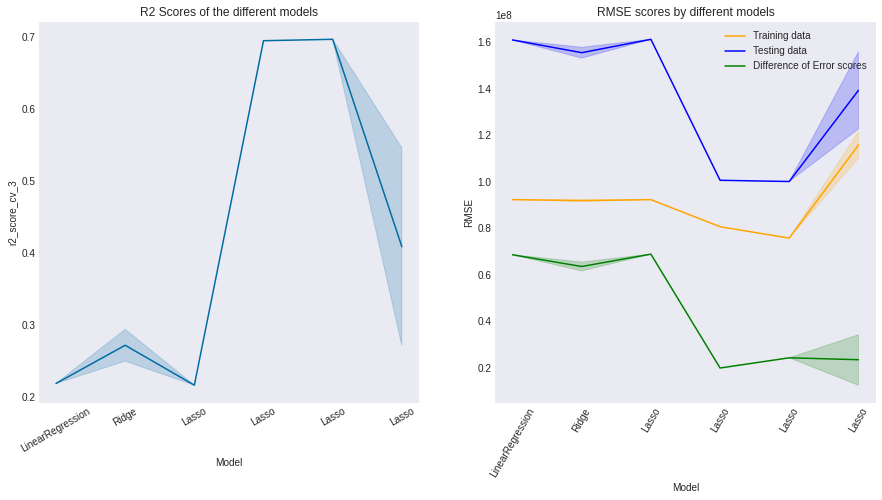

In [ ]:
fig ,(ax1, ax2) = plt.subplots(1, 2, figsize = [15,7])

sns.lineplot(x = res["Model"], y = res["r2_score_cv_3"], dashes = True, markers = "x", ax= ax1)
ax1.set_xticklabels(res["Model"],rotation = 30)
ax1.set_title("R2 Scores of the different models")


sns.lineplot(x = res["Model"], y = res["Train RMSE"], color = "orange", label = "Training data", ax = ax2)
sns.lineplot(x = res["Model"], y = res["Test RMSE"], color = "blue", label = "Testing data", ax = ax2)
sns.lineplot(x = res["Model"], y = res["Test-Train RMSE"], color = "green", label = "Difference of Error scores", ax = ax2)

ax2.set_ylabel("RMSE")
ax2.set_xlabel("Model")
ax2.set_xticklabels(res["Model"], rotation = 60)
ax2.set_title("RMSE scores by different models")
plt.show()

## Conclusion

<font color="hotpink">

</font>


We have seen that catboost regressor have done a better job at estimating both middle and high revenued movies. But at the end of the day, the Random Forest has done a considerably better job too. In the data we see on top, we see that the cumulative difference between the test and train data is least in RFR. Therefore mainly we will be choosing the *Random Forest Regressor* as our last solution.

But if more data were obtained and more highly revenued movies were to be observed for our problem, we would go with the Catboost Algorithm, as it does have a overfitting detector that stops trees being built after the automatically defined threshold.

Furthermore, we realize that taking the most frequent features add up some bias to our solution, but we are not expecting that most companies will not be curious about how hiring an actor who earns millions of dollars will effect the quality and the revenue of the movie. So this is a report mostly created for companies that are competitive in the movie industry right now.

## Future Applications & Project Outlines

* By this project we have been able to see and implement how continuous data could be predicted by the help of some of the ML algorithms.

* We have been able to identify the problem and  test the models accordingly and choose the right recipe for our problem.

* We have found some important insights about the genre, company, cast and crew information, like Animation has a bigger effect while predicting the revenues, similarly Brad Pitt has a bigger effect than the other cast.

* The cast facebook total likes by the following of actor_1 facebook likes indicate a high feature importance, meaning that the data retrieved from facebook is having an important role for guessing the revenue prices.



### A neural Network Model for TMDB Movies with different variables.

The neural networks could be used for regression tasks where we have a continuous variable(or variables) to predict instead of discrete outcomes. We will use some basic techniques with a neural network, then we will proceed to the deep neural networks with hidden layers. Let's first start with a small network predicting the revenues of the movies by the budgets.

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


np.set_printoptions(precision = 3, suppress = True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_probability as tfp
print(tf.__version__)

2.4.1


In [88]:
from sklearn.model_selection import train_test_split
# features = ['budget','runtime', 'popularity', 'vote_average',
#        'vote_count','revenue']
# df_numeric = df_num[features]
#let's try all the features used in upper models. On neural networks.

##handle here.
df_numeric = df_num.select_dtypes(include = ["int64", "float64", "int32", "float64"])

X = df_numeric.drop(columns = ["revenue"])
y = df_numeric["revenue"]
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.2,random_state = 42)

In [89]:
from scipy import stats
def transformation(df_num): # for decreasing the skew

  #choose only the numeric columns
  numeric_df = df_num.iloc[:, :8]
  numeric_df = numeric_df.select_dtypes(include =["int64", "int32", "float64"])
  columns = numeric_df.columns
  
  #create a dict of skewed features containing the skews and names of columns, next time skew the same ones or check it.
  save_skewed = {}
  lambdas = {}
  for col in columns:
    if df_num[col].skew() > 4.5:
      save_skewed[col] = df_num[col].skew()
      #transform the features with this
      df_num[col], fitted_lambda = stats.yeojohnson(df_num[col])
      lambdas[col] = fitted_lambda
    else:
      pass
  
  return save_skewed, df_num, lambdas

skewed_feats, train_features, lambds_yeo = transformation(train_features)
# np.isneginf(tr).sum()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [90]:
def transformation_test(test_features, lambdas, save_skewed): #we will use the lambdas of training transformations to transform the test data.
  test_numeric = test_features.iloc[:, :8]
  test_numeric = test_numeric.select_dtypes(include = ["float64", "int64", "int32", "float32"])
  columns = test_numeric.columns
  
  for col in columns:
    if col in list(save_skewed.keys()):
      #transform the features with this
      test_features[col]= stats.yeojohnson(x = test_features[col], lmbda =lambdas[col])
    else:
      pass
  
  return test_features, skewed_feats, lambds_yeo

test_features, skewed_feats,lambds_yeo = transformation_test(test_features, lambds_yeo, skewed_feats)
print("Transformed features: ", skewed_feats.keys())

Transformed features:  dict_keys(['popularity', 'director_facebook_likes'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


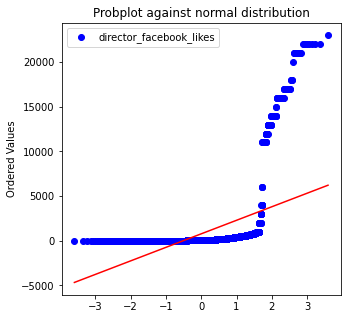

In [91]:
fig, ax1 = plt.subplots(figsize = [5,5])
prob = stats.probplot(X["director_facebook_likes"],dist = 'norm', plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')
plt.legend(["director_facebook_likes"])
plt.show()

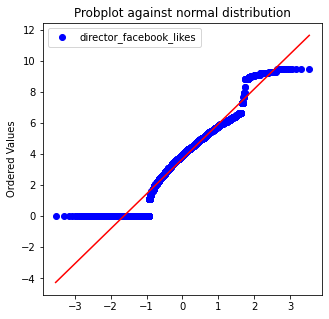

In [92]:
fig, ax1 = plt.subplots(figsize = [5,5])
prob = stats.probplot(train_features["director_facebook_likes"],dist = 'norm', plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')
plt.legend(["director_facebook_likes"])
plt.show()

In [93]:
df_num.loc[df_num.director_facebook_likes < 0]["revenue"].count()

0

<Figure size 864x360 with 0 Axes>

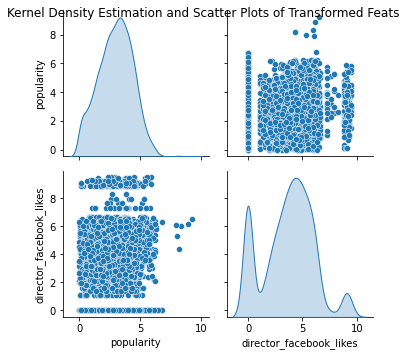

In [94]:
plt.figure(figsize = [12,5])
sns.pairplot(train_features[skewed_feats.keys()], diag_kind = "kde");
plt.suptitle("Kernel Density Estimation and Scatter Plots of Transformed Feats");
plt.tight_layout()
plt.show()

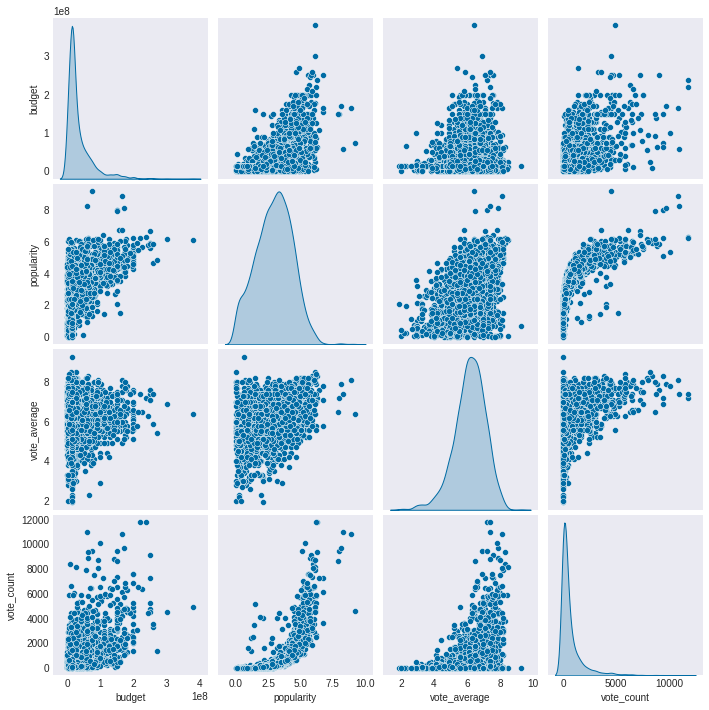

In [ ]:
sns.pairplot(train_features[["budget", "popularity", "vote_average","vote_count"]],diag_kind = "kde")

Splitting the data, by deleting the string columns, as we have converted them to one-hot vectors.

### Linear Regression

Predicting Revenue from budget only

In [ ]:
budget = np.array(train_features["budget"])

budget_Normalizer = preprocessing.Normalization(input_shape = [1,])
budget_Normalizer.adapt(budget)


In [ ]:
budget_model = tf.keras.Sequential([
                                    budget_Normalizer, #also our norm vector (our input)
                                    layers.Dense(units = 1)
])

budget_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [ ]:
budget_model.predict(budget)

array([[-0.047],
       [-0.09 ],
       [ 0.024],
       ...,
       [-0.092],
       [-0.065],
       [-0.065]], dtype=float32)

Let's do compiling, apply the training procedure with model.compile method.

In [ ]:
budget_model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.1),
                     loss = "mean_absolute_error")


In [ ]:
%%time

history = budget_model.fit(train_features["budget"],
                           train_labels,
                           epochs = 100,
                           batch_size = 32,
                           verbose = 0,
                           validation_split = 0.2)

CPU times: user 17.1 s, sys: 836 ms, total: 17.9 s
Wall time: 15.6 s


In [ ]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

loss    val_loss  epoch
95  91567480.0  95733200.0     95
96  91567456.0  95733200.0     96
97  91567464.0  95733200.0     97
98  91567448.0  95733176.0     98
99  91567432.0  95733168.0     99

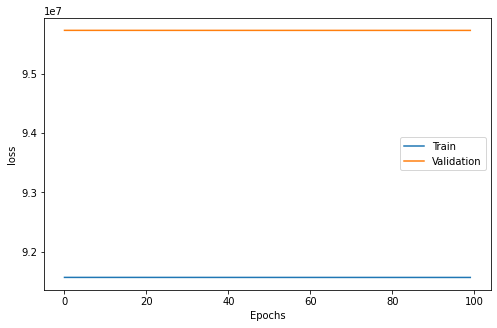

In [ ]:
def plot_loss_history(hist):
  fig = plt.subplots(figsize = [8,5])
  sns.lineplot(x =hist["epoch"],y= hist["loss"], label = "Train")
  sns.lineplot(x= hist["epoch"],y= hist["val_loss"], label = "Validation")
  plt.legend()
  plt.xlabel("Epochs")
  plt.show()

plot_loss_history(hist)

In [ ]:
test_results = {}

test_results["budget_model"] = budget_model.evaluate(test_features["budget"],
                                                     test_labels,
                                                     verbose = 0)

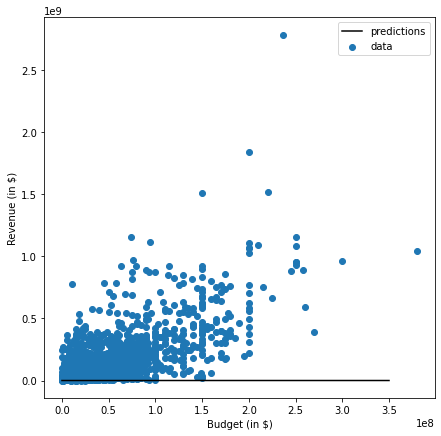

In [ ]:
x = tf.linspace(3000, 350000000, len(train_features))
y = budget_model.predict(x)

def plot_budget(x, y):
  fig = plt.subplots(figsize = [7,7])
  plt.scatter(train_features["budget"], train_labels, label = "data") #plot the predictions as scatter
  plt.plot(x, y ,color = 'k', label = "predictions")
  plt.xlabel("Budget (in $)")
  plt.ylabel("Revenue (in $)")
  plt.legend()
  plt.show()

plot_budget(x, y)

The model although it was giving plasuible results have given values of nan for loss after I have applied log_transformation to some values. It seems to have created a vanishing gradient problem. In order to fix this issue, I will be turning back to where I have started logs and fix the issue.

### Build The Model and Compile & Normalize Input Norm

In [ ]:
train_features.shape

(3377, 297)

# Come here and write this Transformation, The Model is waiting for you!.

In [ ]:
df_num[:,8:].columns

In [97]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler


#write a pipeline which only standardizes the numeric features.
#maybe use a MultiLabelEncoding to encode the keywords, genres, crew, companies, language and so forth.

scaler = StandardScaler()
scaler2 = StandardScaler()

train_features_trans = scaler.fit_transform(train_features)
test_features_trans = scaler2.fit_transform(test_features)

In [ ]:
first = np.array(train_features[:1])

with np.printoptions(precision = 3, suppress = True):
  print("First example: ",first)
  print()
  #print("Normalized: ", normalizer(first).numpy())

### Try same model with multiple inputs

In [ ]:
linear_model = tf.keras.Sequential([
                                    
                                    layers.Dense(units = 1)
])

In [ ]:
linear_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate = 0.1),
    loss = "mean_absolute_error"
)

In [ ]:
%%time
history = linear_model.fit(train_features,
                           train_labels,
                           epochs= 100,
                           verbose = 0,
                           validation_split = 0.2)

CPU times: user 24.3 s, sys: 1.49 s, total: 25.8 s
Wall time: 22.4 s


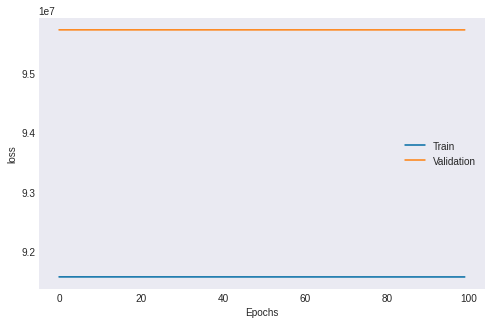

In [ ]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch

plot_loss_history(hist)

#### Create a DNN Regression
These models will contain more layers then the linear model:

- The normalization layer
- Two hidden non-linear layers using relu non-linearity
- A linear single-output layer 

#### Budget DNN

In [ ]:
dnn_budget_model = build_and_compile(budget_Normalizer)

dnn_budget_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 1)                 3         
_________________________________________________________________
1st (Dense)                  (None, 512)               1024      
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
2nd (Dense)                  (None, 512)               262656    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
3rd (Dense)                  (None, 128)               65664     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)              

In [ ]:
history = dnn_budget_model.fit(train_features["budget"],
                               train_labels,
                               epochs = 10,
                               validation_split = 0.2,
                               verbose = 2)

Epoch 1/10
85/85 - 2s - loss: 91565744.0000 - val_loss: 95717000.0000
Epoch 2/10
85/85 - 1s - loss: 91469288.0000 - val_loss: 95499240.0000
Epoch 3/10
85/85 - 1s - loss: 91094896.0000 - val_loss: 94921368.0000
Epoch 4/10
85/85 - 1s - loss: 90300472.0000 - val_loss: 93843960.0000
Epoch 5/10
85/85 - 1s - loss: 88970968.0000 - val_loss: 92201544.0000
Epoch 6/10
85/85 - 1s - loss: 87094888.0000 - val_loss: 89996200.0000
Epoch 7/10
85/85 - 1s - loss: 84620520.0000 - val_loss: 87325232.0000
Epoch 8/10
85/85 - 1s - loss: 81685528.0000 - val_loss: 84261632.0000
Epoch 9/10
85/85 - 1s - loss: 78377280.0000 - val_loss: 80956000.0000
Epoch 10/10
85/85 - 1s - loss: 75525128.0000 - val_loss: 78400920.0000


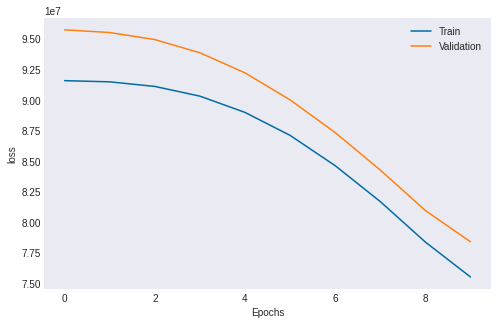

In [ ]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
plot_loss_history(hist)

### Full model (multivariate Regression with DNN)

In [98]:
np.set_printoptions(precision = 3, suppress = True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [99]:
def plot_loss_history(hist):
  fig = plt.subplots(figsize = [8,5])
  sns.lineplot(x =hist["epoch"],y= hist["loss"], label = "Train")
  sns.lineplot(x= hist["epoch"],y= hist["val_loss"], label = "Validation")
  plt.legend()
  plt.xlabel("Epochs")
  plt.show()

In [ ]:
from tensorflow.keras.constraints import max_norm
def build_and_compile(norm):

  model = keras.Sequential([
                            norm,
                            layers.Dense(1024, activation = "relu" , name = "1st", kernel_regularizer = tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01)), #elastic net with 0.01 lasso, 0.05 ridge
                            layers.Dropout(0.5, seed = 42),
                            layers.Dense(1024, activation ="relu", kernel_constraint = max_norm(3.) ,name = "2nd"),
                            layers.Dropout(0.5, seed = 42),
                            layers.Dense(512, activation = "relu",name = "3rd",kernel_constraint = max_norm(3.)), #ridge regularizer (l2 norm)
                            layers.Dropout(0.5, seed = 42),
                            layers.Dense(512, activation = "relu"),
                            layers.LeakyReLU(alpha = 0.3),
                            layers.Dropout(0.3),
                            layers.Dense(256, activation = "relu"),
                            layers.Dense(1,activation='linear',name = "last")
  ])

  model.compile(optimizer ='adam' , loss = "mean_absolute_error")
  return model

In [102]:
# we have done it in linear regression but just to see required norm operation
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

#full_model = build_and_compile(normalizer)

#full_model.summary()

In [ ]:
%%time
callback_1 = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",min_delta = 100000, patience = 40, verbose = 1,mode = "min", restore_best_weights= True)
history = full_model.fit(train_features,
                         train_labels,
                         epochs = 50,
                         batch_size = 64,
                         validation_split = 0.2,
                         verbose = 1,
                         callbacks = [callback_1])

Epoch 1/50
43/43 [==============================] - 3s 62ms/step - loss: 87940063.0909 - val_loss: 91560472.0000
Epoch 2/50
43/43 [==============================] - 2s 50ms/step - loss: 85010748.7273 - val_loss: 72186168.0000
Epoch 3/50
43/43 [==============================] - 2s 50ms/step - loss: 61564238.1818 - val_loss: 55009424.0000
Epoch 4/50
43/43 [==============================] - 2s 50ms/step - loss: 47432366.3636 - val_loss: 49122616.0000
Epoch 5/50
43/43 [==============================] - 2s 50ms/step - loss: 43139982.6364 - val_loss: 46839344.0000
Epoch 6/50
43/43 [==============================] - 2s 51ms/step - loss: 41493856.2727 - val_loss: 45649896.0000
Epoch 7/50
43/43 [==============================] - 2s 51ms/step - loss: 37029286.6818 - val_loss: 43264460.0000
Epoch 8/50
43/43 [==============================] - 2s 49ms/step - loss: 34580952.0000 - val_loss: 41864788.0000
Epoch 9/50
43/43 [==============================] - 2s 49ms/step - loss: 37387312.8182 - val_los

1) First basic multi perceptron model: loss: 44335648 - val_loss: 40892204

#### Small investigation on the weights and biases of the model layers.

By this search, I will decide on the weight parameter that I want to add. It will help me to decide on the parameters of kernel constraints of given layer. If a layer increases the bias or weights of a particular object unexpectedly, I will be shrinking the parameters accordingly, in order to decrease overfit.

In [ ]:

"""print(f"weights for {full_model.layers[1].name}: {full_model.layers[1].weights}")
print(f"bias for {full_model.layers[1].name}: {full_model.layers[1].bias.numpy()}")
print(f"bias initializer  for {full_model.layers[1].name}: {full_model.layers[1].bias_initializer}")
"""
w = full_model.layers[1].weights

def count_big_weights(w, weight_lim = 1):
  
  count_dict = {}
  w = w[0].numpy()
  for idx, neuron in enumerate(w):
    count_max = 0
    for i in neuron:
      if i > weight_lim:
        count_max += 1
    count_dict["neuron_"+str(idx)] = count_max
  return count_dict

d = count_big_weights(w)


In [ ]:
for k,v in d.items():
  if v > 0:
    print(k, v)

neuron_1 183
neuron_2 1
neuron_3 156
neuron_4 135
neuron_221 4
neuron_271 1
neuron_288 451
neuron_289 449


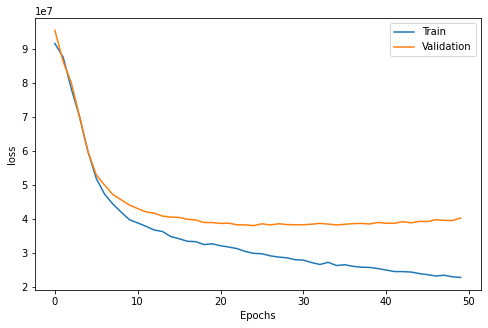

In [ ]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
plot_loss_history(hist)

### Evaluate the test results of the Model

In [ ]:
test_results["full_model_transformed_32_batch"] = full_model.evaluate(test_features,
                                                 test_labels,
                                                 verbose = 0)

In [ ]:
test_results

{'budget_model': 107142352.0,
 'full_model_transformed': 52193548.0,
 'full_model_transformed_128_batch': 52193548.0,
 'full_model_transformed_32_batch': 49412996.0}

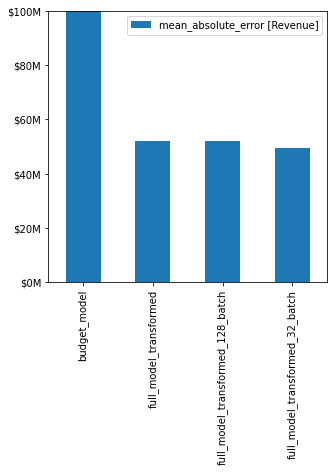

In [ ]:
import matplotlib.ticker as mtick

def numfmt(x, pos):
  return "$%.0fM" % (x/1000000)
yfmt = mtick.FuncFormatter(numfmt)

fig, ax1 = plt.subplots(1,1, figsize = [5,5])
pd.DataFrame(data = test_results, index = ["mean_absolute_error [Revenue]"]).T.plot.bar(ax= ax1)
plt.ylim([0, 10e7])
ax1.yaxis.set_major_formatter(yfmt)

### Make Predictions

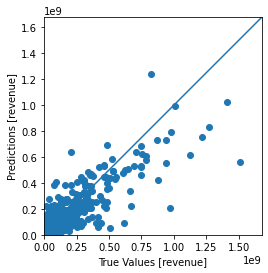

In [ ]:
test_predictions = full_model.predict(test_features).flatten()
a = plt.axes(aspect = "equal")
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [revenue]')
plt.ylabel('Predictions [revenue]')

lims = [0,test_labels.max()+1.7*10e7]
plt.xlim(lims)
plt.ylim(lims)

_ = plt.plot(lims, lims)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


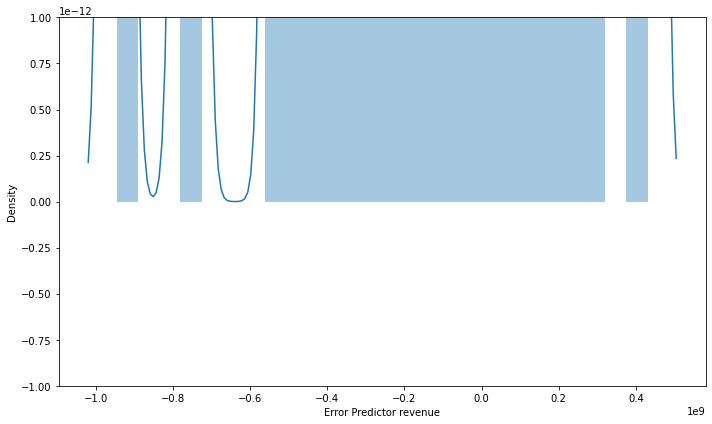

In [ ]:
error = test_predictions - test_labels

plt.figure(figsize = [10,6])
sns.distplot(error, bins = 25)
plt.xlabel("Error Predictor revenue")
plt.tight_layout()
plt.show()

In [ ]:
full_model.save("easy_model")

INFO:tensorflow:Assets written to: easy_model/assets


In [ ]:
pd.DataFrame(test_results, index = ["Mean_Absolute_Error (revenue)","same"]).T

Mean_Absolute_Error (revenue)         same
budget_model                                        107142352.0  107142352.0
full_model_transformed                               52193548.0   52193548.0
full_model_transformed_128_batch                     52193548.0   52193548.0
full_model_transformed_32_batch                      49412996.0   49412996.0